## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI2D-axial' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
vertical_wavelet_axial_syntheticMRI2D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI2D/axial/wavelet/vertical'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 4,
 3: 20050,
 4: 180942,
 5: 922650,
 6: 4185552,
 7: 17688454,
 8: 72685058,
 9: 295085108}

Running 12760 CDFs


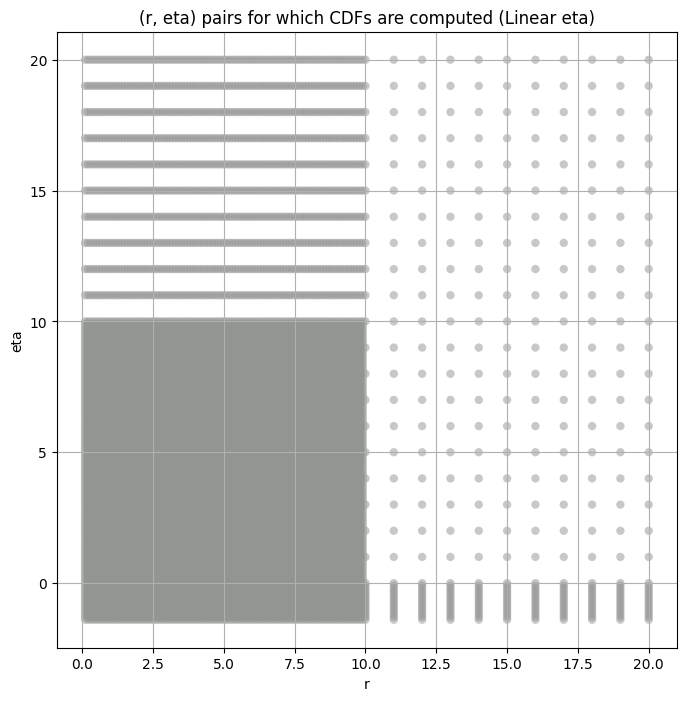

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:29<00:00, 3442.56it/s]


Layer 3


100%|██████████| 100000/100000 [00:46<00:00, 2128.81it/s]


Layer 4


100%|██████████| 100000/100000 [00:41<00:00, 2421.36it/s]


Layer 5


100%|██████████| 100000/100000 [00:41<00:00, 2434.60it/s]


Layer 6


100%|██████████| 100000/100000 [00:41<00:00, 2435.79it/s]


Layer 7


100%|██████████| 100000/100000 [00:41<00:00, 2427.02it/s]


Layer 8


100%|██████████| 100000/100000 [00:41<00:00, 2435.53it/s]


Layer 9


100%|██████████| 100000/100000 [00:41<00:00, 2398.70it/s]


obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.514066e+07  0.000000e+00  4.665707e+07  -1.892597         NaN   
3      2.194724e+06  2.157541e+06  2.231273e+06  -1.577773   -1.605638   
4      1.783252e+05  1.708648e+05  1.860050e+05   0.721045    0.336479   
5      9.722950e+04  9.013892e+04  1.045902e+05   6.273305    5.559395   
6      3.331691e+04  3.032871e+04  3.646762e+04  10.891587    9.727513   
7      7.128587e+03  6.485395e+03  7.798545e+03  10.925105    9.578980   
8      7.198787e+02  6.507919e+02  7.955521e+02  12.979091   10.335731   
9      6.299376e+01  5.491660e+01  7.264558e+01  27.372496   15.878567   

       kurt_upper  total_samples  
layer                             
2             NaN            4.0  
3       -1.544034        20050.0  
4        1.257031       180942.0  
5        7.024289       922650.0  
6       12.124202      4185552.0  
7       12.388499     17688454.0  
8       20.882729     72685058.0  
9       56.057470    295085108.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      3.514066e+07   3.514066e+07             NaN             NaN   
3      2.194724e+06   2.194724e+06    2.175920e+06    2.165423e+06   
4      1.783252e+05   1.783252e+05    1.760044e+05    1.744029e+05   
5      9.722950e+04   9.722950e+04    9.547334e+04    9.401342e+04   
6      3.331691e+04   3.331691e+04    3.251155e+04    3.183361e+04   
7      7.128587e+03   7.128587e+03    6.940842e+03    6.782351e+03   
8      7.198787e+02   7.198787e+02    6.953624e+02    6.776449e+02   
9      6.299376e+01   6.299376e+01    5.858568e+01    5.630242e+01   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3        2.156079e+06     2.147362e+06     2.131066e+06     2.115720e+06   
4        1.730475e+05     1.718165e+05     1.696404e+05     1.677736e+05   
5        9.267102e+04     9.141355e+04     8.906828e+04     8.689953e+04   
6        3.121127e+04     3.062906e+04     2.955125e+04     2.856238e+04   
7        6.639799e+03     6.509483e+03     6.276635e+03     6.071052e+03   
8        6.618804e+02     6.475551e+02     6.221575e+02     5.999875e+02   
9        5.445492e+01     5.285530e+01     5.011671e+01     4.779826e+01   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3         2.101058e+06     2.086816e+06     2.072988e+06     2.033132e+06  
4         1.660979e+05     1.645653e+05     1.631211e+05     1.591750e+05  
5         8.488321e+04     8.298902e+04     8.119630e+04     7.633512e+04  
6         2.764415e+04     2.678389e+04     2.597497e+04     2.380846e+04  
7         5.884930e+03     5.713697e+03     5.554594e+03     5.133235e+03  
8         5.801822e+02     5.621920e+02     5.456519e+02     5.026105e+02  
9         4.578465e+01     4.400681e+01     4.241389e+01     3.843280e+01

####
Layer  2


100%|██████████| 12760/12760 [00:00<00:00, 24180.74it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.29903335551069465 35140656.0


100%|██████████| 12760/12760 [00:00<00:00, 27562.50it/s]


Finding Minimum after computing 12760 CDFs
2 25 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 30693.58it/s]


Finding Minimum after computing 12760 CDFs
2 50 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31320.71it/s]


Finding Minimum after computing 12760 CDFs
2 75 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31331.80it/s]


Finding Minimum after computing 12760 CDFs
2 100 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 29249.83it/s]


Finding Minimum after computing 12760 CDFs
2 150 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31404.37it/s]


Finding Minimum after computing 12760 CDFs
2 200 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31412.24it/s]


Finding Minimum after computing 12760 CDFs
2 250 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31496.22it/s]


Finding Minimum after computing 12760 CDFs
2 300 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31506.64it/s]


Finding Minimum after computing 12760 CDFs
2 350 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31364.83it/s]


Finding Minimum after computing 12760 CDFs
2 500 nan nan
Number of samples: 4, Without approximation : 4.0


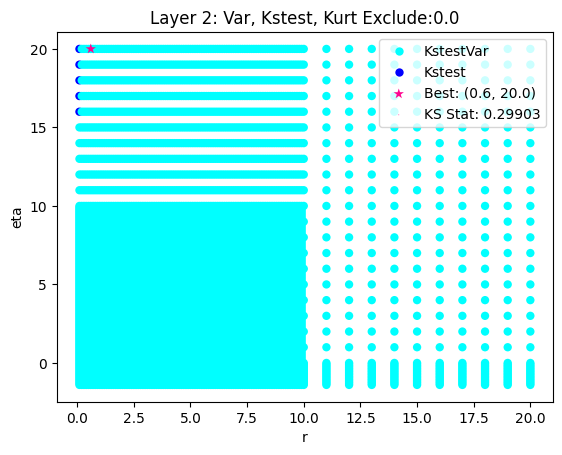

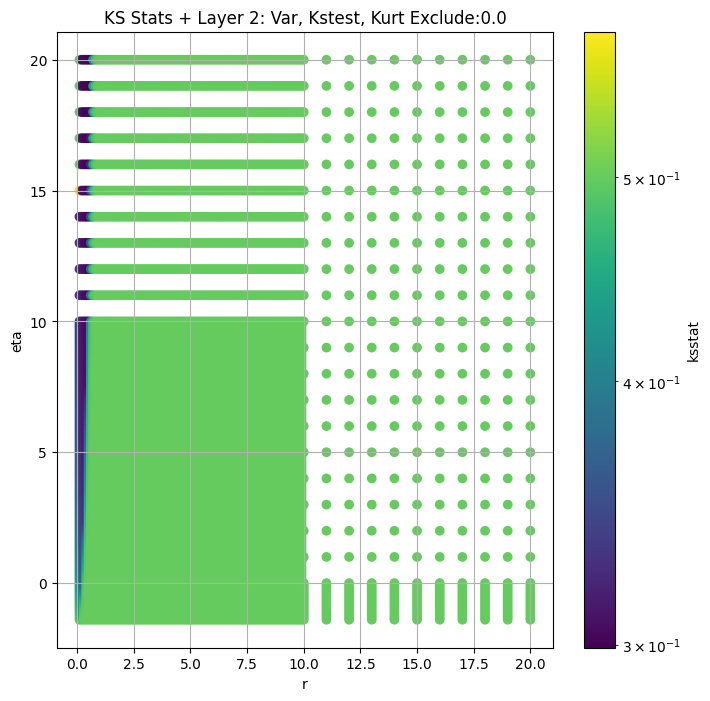

####
Layer  3


100%|██████████| 12760/12760 [00:08<00:00, 1445.67it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.14204333162407407 2194723.8


100%|██████████| 12760/12760 [00:08<00:00, 1452.67it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.14302680642868407 2175920.0


100%|██████████| 12760/12760 [00:08<00:00, 1446.91it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.1435801870258029 2165423.0


100%|██████████| 12760/12760 [00:08<00:00, 1452.65it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.14405687476558202 2156078.8


100%|██████████| 12760/12760 [00:08<00:00, 1450.78it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.1441976775576402 2147361.8


100%|██████████| 12760/12760 [00:08<00:00, 1448.77it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.14507188030704996 2131066.5


100%|██████████| 12760/12760 [00:08<00:00, 1440.67it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.14590238599911634 2115720.0


100%|██████████| 12760/12760 [00:08<00:00, 1453.34it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.14670249149659148 2101057.5


100%|██████████| 12760/12760 [00:08<00:00, 1450.58it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.1474858885581734 2086816.1


100%|██████████| 12760/12760 [00:08<00:00, 1445.40it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.1482525365453829 2072988.1


100%|██████████| 12760/12760 [00:08<00:00, 1451.19it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.1504959201027288 2033132.2
Number of samples: 20050, Without approximation : 20050.0


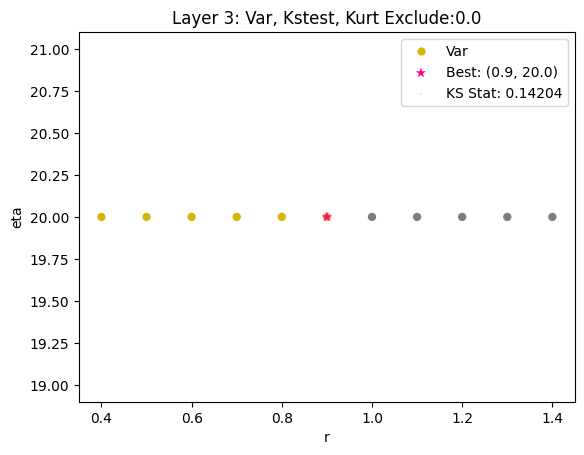

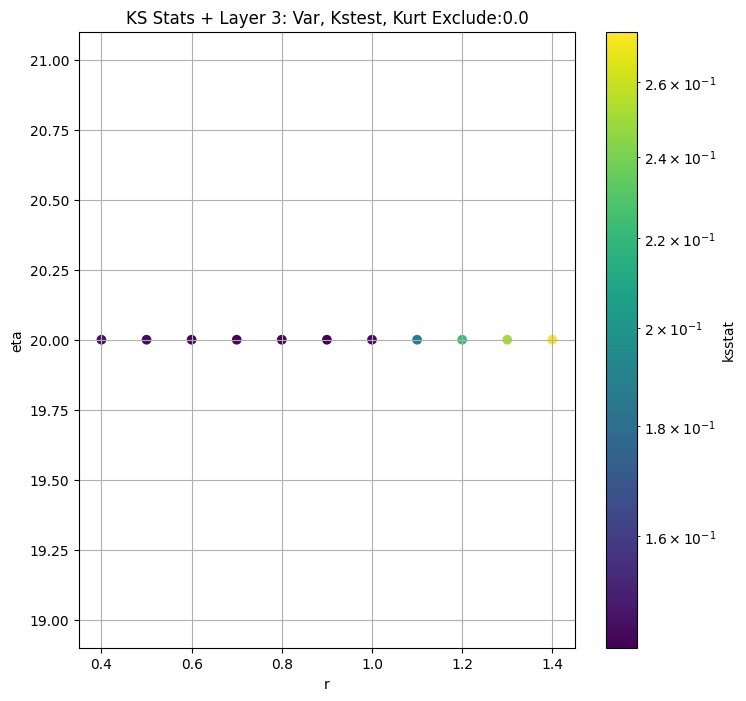

####
Layer  4


100%|██████████| 12760/12760 [00:42<00:00, 301.12it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.019374906087038846 178325.16


100%|██████████| 12760/12760 [00:42<00:00, 298.53it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.02043633474752804 176004.44


100%|██████████| 12760/12760 [00:42<00:00, 302.97it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.02121036834829415 174402.86


100%|██████████| 12760/12760 [00:42<00:00, 303.27it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.021850808590798576 173047.45


100%|██████████| 12760/12760 [00:41<00:00, 304.69it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.022461958709144914 171816.5


100%|██████████| 12760/12760 [00:41<00:00, 304.48it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.0235591301082424 169640.44


100%|██████████| 12760/12760 [00:41<00:00, 304.65it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.024494491247237904 167773.6


100%|██████████| 12760/12760 [00:41<00:00, 304.62it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.02536853373621073 166097.94


100%|██████████| 12760/12760 [00:41<00:00, 304.27it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.02615550754602025 164565.31


100%|██████████| 12760/12760 [00:41<00:00, 304.54it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.026928392686971003 163121.11


100%|██████████| 12760/12760 [00:41<00:00, 304.02it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.02906783278037328 159175.05
Number of samples: 100000, Without approximation : 180942.0


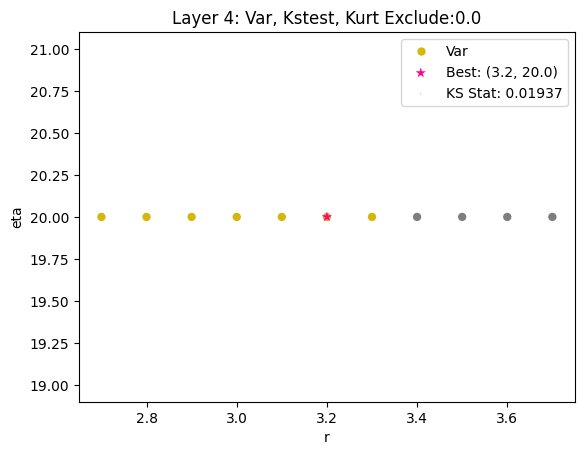

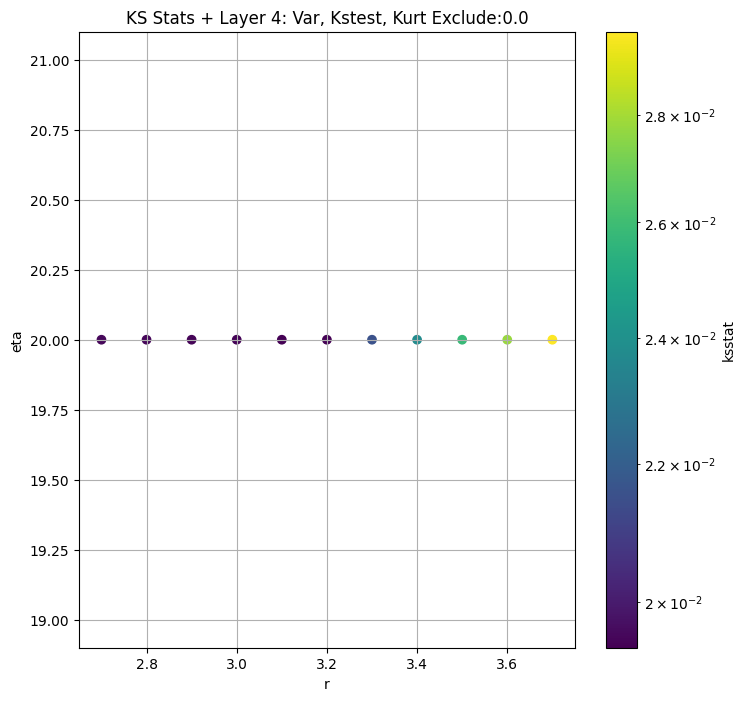

####
Layer  5


100%|██████████| 12760/12760 [00:41<00:00, 305.61it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.00820158085668922 97229.5


100%|██████████| 12760/12760 [00:41<00:00, 305.84it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.007824866524624996 95473.34


100%|██████████| 12760/12760 [00:41<00:00, 305.98it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.007242035513122927 94013.42


100%|██████████| 12760/12760 [00:41<00:00, 305.58it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.006805822970080311 92671.02


100%|██████████| 12760/12760 [00:41<00:00, 305.67it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.006722264233247899 91413.55


100%|██████████| 12760/12760 [00:41<00:00, 305.39it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.006643243784541508 89068.28


100%|██████████| 12760/12760 [00:41<00:00, 305.49it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.006394727090331882 86899.53


100%|██████████| 12760/12760 [00:41<00:00, 304.02it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.006885837873126244 84883.21


100%|██████████| 12760/12760 [00:41<00:00, 305.27it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.007291604622265671 82989.02


100%|██████████| 12760/12760 [00:41<00:00, 305.33it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.007730959606625839 81196.3


100%|██████████| 12760/12760 [00:41<00:00, 305.22it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.00899571143838962 76335.12
Number of samples: 100000, Without approximation : 922650.0


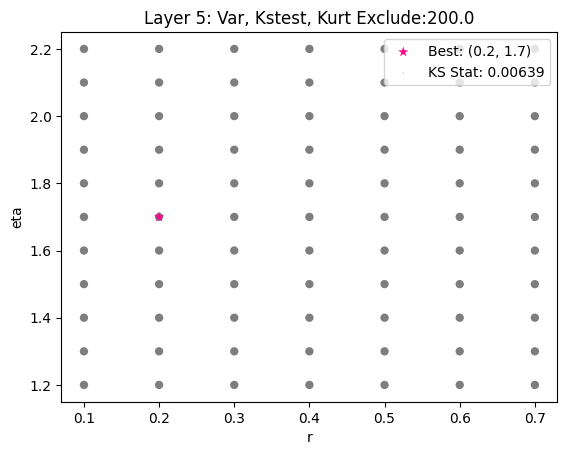

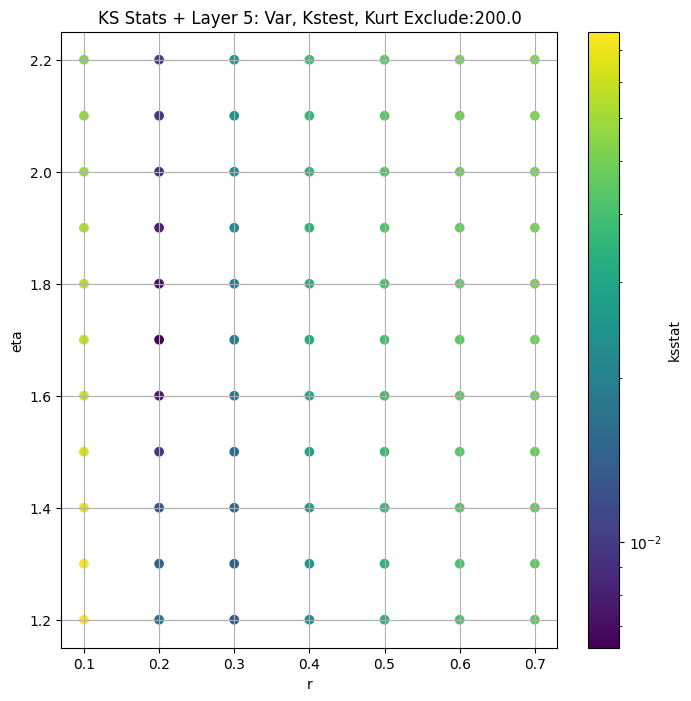

####
Layer  6


100%|██████████| 12760/12760 [00:41<00:00, 305.86it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.014486312142038327 33316.914


100%|██████████| 12760/12760 [00:41<00:00, 304.57it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.01355237930436877 32511.553


100%|██████████| 12760/12760 [00:41<00:00, 304.94it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.012624949718613498 31833.605


100%|██████████| 12760/12760 [00:41<00:00, 304.30it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.013981659572111338 31211.271


100%|██████████| 12760/12760 [00:41<00:00, 305.27it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.013724176567639801 30629.06


100%|██████████| 12760/12760 [00:41<00:00, 305.35it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.012509583610848085 29551.254


100%|██████████| 12760/12760 [00:41<00:00, 305.08it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.010945900546110998 28562.383


100%|██████████| 12760/12760 [00:41<00:00, 304.68it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.009836896674906725 27644.154


100%|██████████| 12760/12760 [00:42<00:00, 301.59it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.010136567948280883 26783.887


100%|██████████| 12760/12760 [00:42<00:00, 302.79it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.010386239365839933 25974.973


100%|██████████| 12760/12760 [00:42<00:00, 303.54it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.008356742681167597 23808.465
Number of samples: 100000, Without approximation : 4185552.0


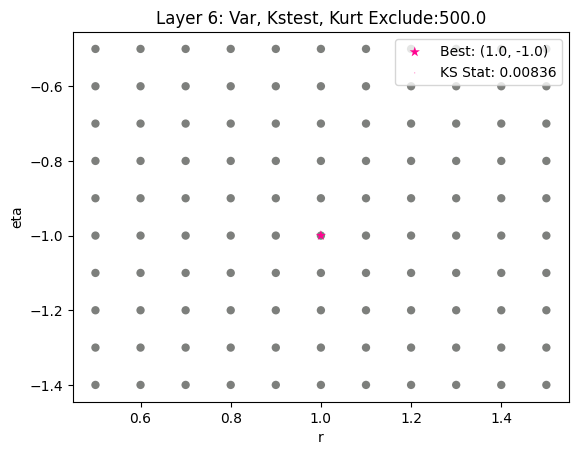

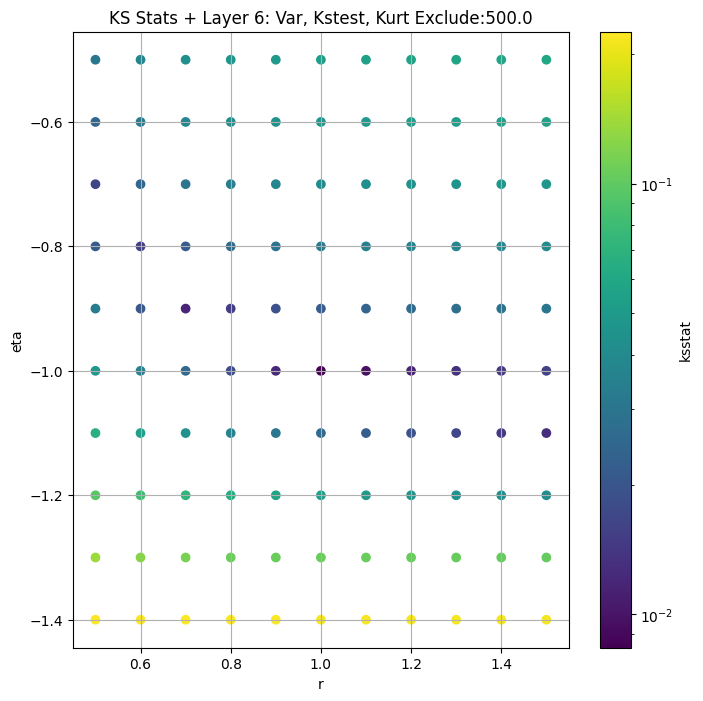

####
Layer  7


100%|██████████| 12760/12760 [00:41<00:00, 304.70it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.012182024648288547 7128.5874


100%|██████████| 12760/12760 [00:42<00:00, 303.69it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.011049527431589379 6940.842


100%|██████████| 12760/12760 [00:41<00:00, 304.64it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.010063077865551273 6782.3506


100%|██████████| 12760/12760 [00:41<00:00, 304.41it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.009165682260644736 6639.799


100%|██████████| 12760/12760 [00:41<00:00, 304.59it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.008644912781006417 6509.4834


100%|██████████| 12760/12760 [00:41<00:00, 304.98it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.008856272959608447 6276.635


100%|██████████| 12760/12760 [00:42<00:00, 302.32it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.011044357225043822 6071.0522


100%|██████████| 12760/12760 [00:42<00:00, 303.14it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.011300188651941226 5884.9297


100%|██████████| 12760/12760 [00:41<00:00, 304.50it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.010425706967295278 5713.697


100%|██████████| 12760/12760 [00:41<00:00, 304.87it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.010810149870357777 5554.594


100%|██████████| 12760/12760 [00:41<00:00, 304.56it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.00942885629709711 5133.235
Number of samples: 100000, Without approximation : 17688454.0


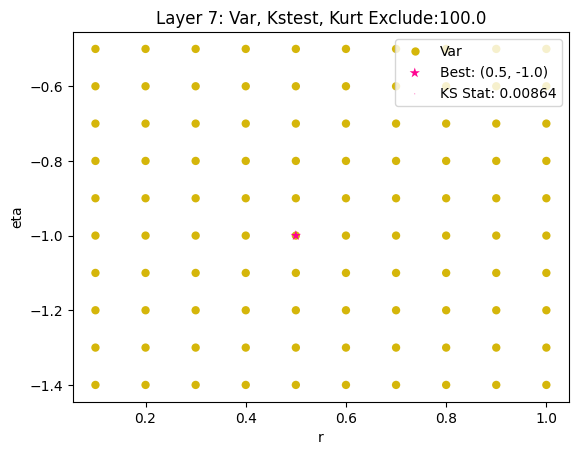

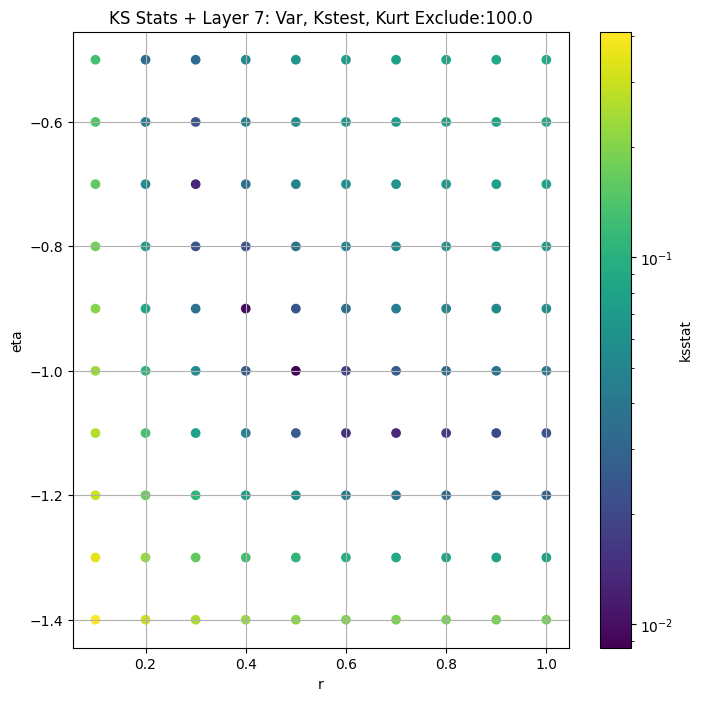

####
Layer  8


100%|██████████| 12760/12760 [00:41<00:00, 304.59it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.011646939722755018 719.8787


100%|██████████| 12760/12760 [00:41<00:00, 304.90it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.010163503630758186 695.3624


100%|██████████| 12760/12760 [00:41<00:00, 304.93it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.00896447029423908 677.6449


100%|██████████| 12760/12760 [00:41<00:00, 304.78it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.007865871703463756 661.8804


100%|██████████| 12760/12760 [00:42<00:00, 303.52it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.006840395692537249 647.55505


100%|██████████| 12760/12760 [00:41<00:00, 304.23it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.005546063530160961 622.15753


100%|██████████| 12760/12760 [00:41<00:00, 304.42it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.00697479806619361 599.9875


100%|██████████| 12760/12760 [00:41<00:00, 304.90it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.009184007864769833 580.1822


100%|██████████| 12760/12760 [00:41<00:00, 304.82it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.010181767619858784 562.19196


100%|██████████| 12760/12760 [00:41<00:00, 304.80it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.008888289056158238 545.6519


100%|██████████| 12760/12760 [00:41<00:00, 304.16it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.008910907829951464 502.61047
Number of samples: 100000, Without approximation : 72685058.0


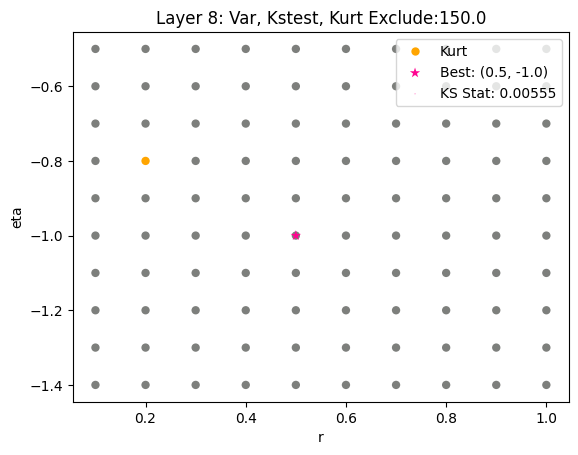

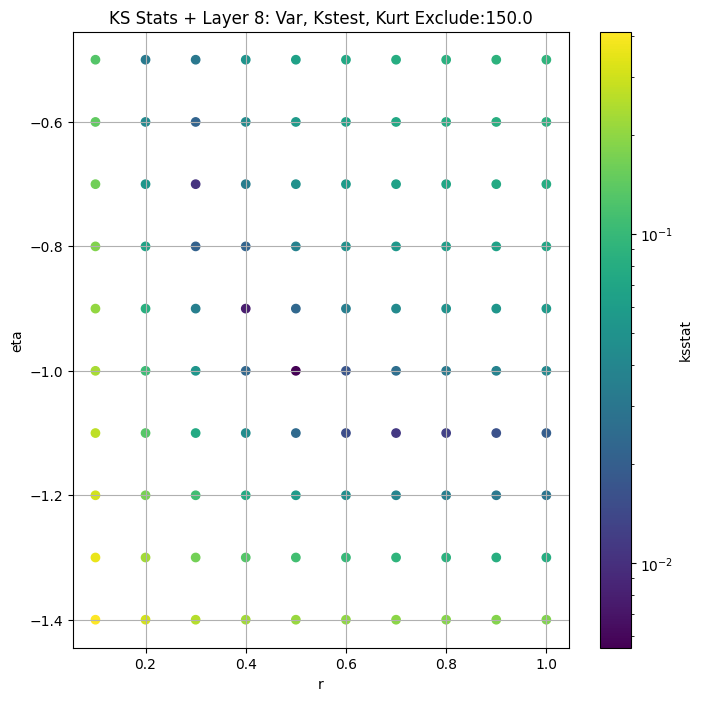

####
Layer  9


100%|██████████| 12760/12760 [00:41<00:00, 303.84it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.004585205755238353 62.99376


100%|██████████| 12760/12760 [00:42<00:00, 303.08it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.004872859784966543 58.585682


100%|██████████| 12760/12760 [00:42<00:00, 302.92it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.004875476603548812 56.30242


100%|██████████| 12760/12760 [00:41<00:00, 304.27it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.00422693699302612 54.45492


100%|██████████| 12760/12760 [00:41<00:00, 304.59it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.004729524319961431 52.8553


100%|██████████| 12760/12760 [00:41<00:00, 304.28it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.005679487190586696 50.11671


100%|██████████| 12760/12760 [00:41<00:00, 303.89it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.007421008830515552 47.798264


100%|██████████| 12760/12760 [00:41<00:00, 304.35it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.0057716302340145575 45.784653


100%|██████████| 12760/12760 [00:42<00:00, 302.69it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.0058872930416205595 44.00681


100%|██████████| 12760/12760 [00:42<00:00, 302.31it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.006584067415540275 42.41389


100%|██████████| 12760/12760 [00:43<00:00, 291.28it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.008955601683989789 38.432804
Number of samples: 100000, Without approximation : 295085108.0


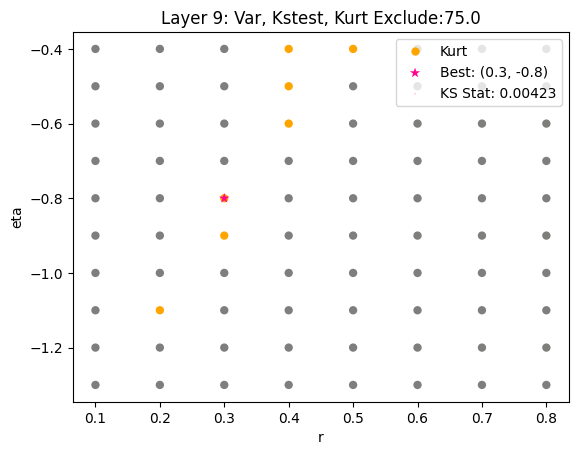

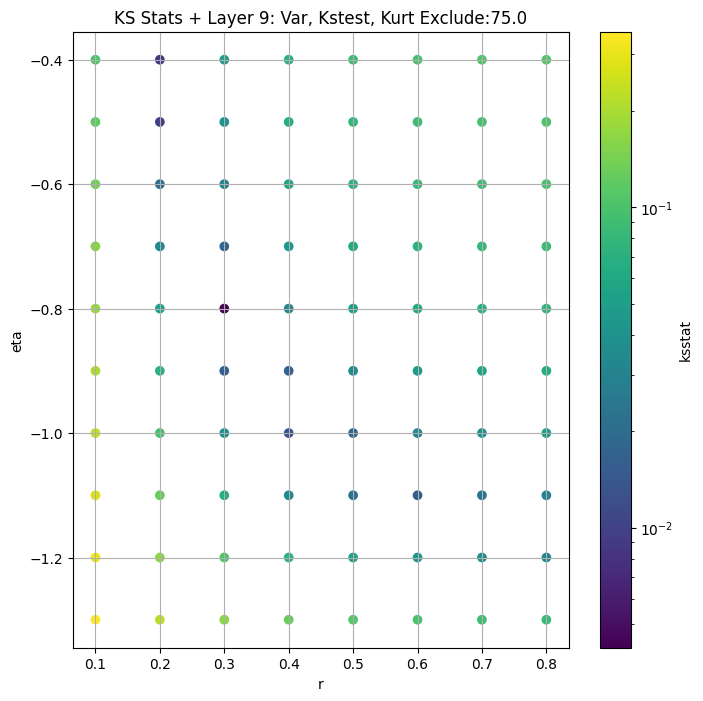

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.514066e+07  0.000000e+00  4.665707e+07  -1.892597         NaN   
3      2.194724e+06  2.157541e+06  2.231273e+06  -1.577773   -1.605638   
4      1.783252e+05  1.708648e+05  1.860050e+05   0.721045    0.336479   
5      9.722950e+04  9.013892e+04  1.045902e+05   6.273305    5.559395   
6      3.331691e+04  3.032871e+04  3.646762e+04  10.891587    9.727513   
7      7.128587e+03  6.485395e+03  7.798545e+03  10.925105    9.578980   
8      7.198787e+02  6.507919e+02  7.955521e+02  12.979091   10.335731   
9      6.299376e+01  5.491660e+01  7.264558e+01  27.372496   15.878567   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            4.0             0.299033        0.6         20.0   
3       -1.544034        20050.0             0.142043        0.9         20.0   
4        1.257031       180942.0             0.019375        3.2         20.0   
5        7.024289       922650.0             0.006395        0.2          1.7   
6       12.124202      4185552.0             0.008357        1.0         -1.0   
7       12.388499     17688454.0             0.008645        0.5         -1.0   
8       20.882729     72685058.0             0.005546        0.5         -1.0   
9       56.057470    295085108.0             0.004227        0.3         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       88852.581511                     0.0        3.514066e+07   
3       64407.782822                     0.0        2.194724e+06   
4       99928.072510                     0.0        1.783252e+05   
5           0.046708                   200.0        8.689953e+04   
6       47616.929688                   500.0        2.380847e+04   
7        3254.741699                   100.0        6.509483e+03   
8         311.078766                   150.0        6.221575e+02   
9           0.944401                    75.0        5.445492e+01   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.623939  
3                     0.009583  
4                     0.003192  
5                     0.001414  
6                     0.000664  
7                     0.000323  
8                     0.000159  
9                     0.000079

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 99/99 [00:00<00:00, 13953.76it/s]


Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 100 = 100, ksstat: nan, var: nan


100%|██████████| 99/99 [00:00<00:00, 21749.22it/s]


Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 75 = 75, ksstat: nan, var: nan


100%|██████████| 99/99 [00:00<00:00, 19839.28it/s]


Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 50 = 50, ksstat: nan, var: nan


100%|██████████| 99/99 [00:00<00:00, 20681.15it/s]


Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 25 = 25, ksstat: nan, var: nan


100%|██████████| 99/99 [00:00<00:00, 22391.94it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.29903335551069465, var: 35140656.0
Number of samples: 4, Without approximation : 4.0


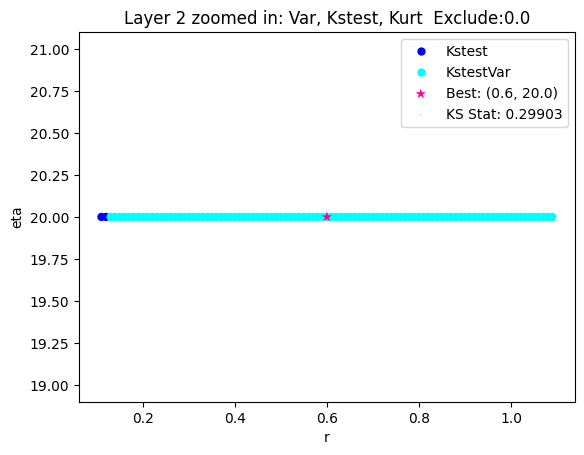

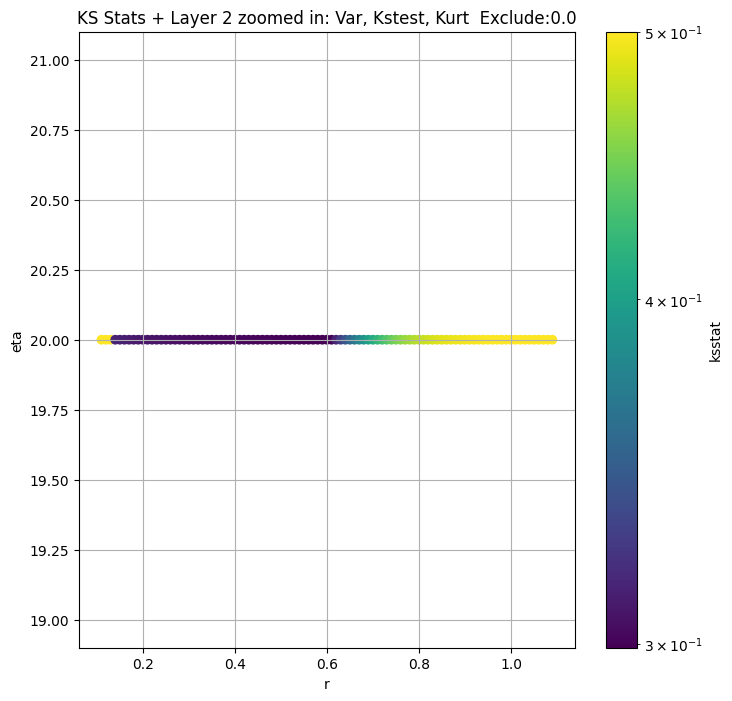

Layer 3


100%|██████████| 100/100 [00:00<00:00, 950.84it/s]


Finding Minimum after computing 100 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.1441976775576402, var: 2147361.75


100%|██████████| 100/100 [00:00<00:00, 1267.08it/s]


Finding Minimum after computing 100 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.14376436483795688, var: 2156078.75


100%|██████████| 100/100 [00:00<00:00, 1403.69it/s]


Finding Minimum after computing 100 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.143268953500526, var: 2165423.0


100%|██████████| 100/100 [00:00<00:00, 1424.32it/s]


Finding Minimum after computing 100 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.14271542112548277, var: 2175920.0


100%|██████████| 100/100 [00:00<00:00, 1410.92it/s]


Finding Minimum after computing 100 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.14173168791289117, var: 2194723.75
Number of samples: 20050, Without approximation : 20050.0


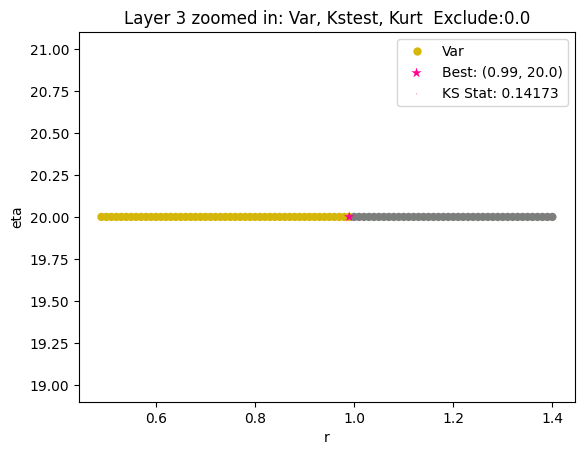

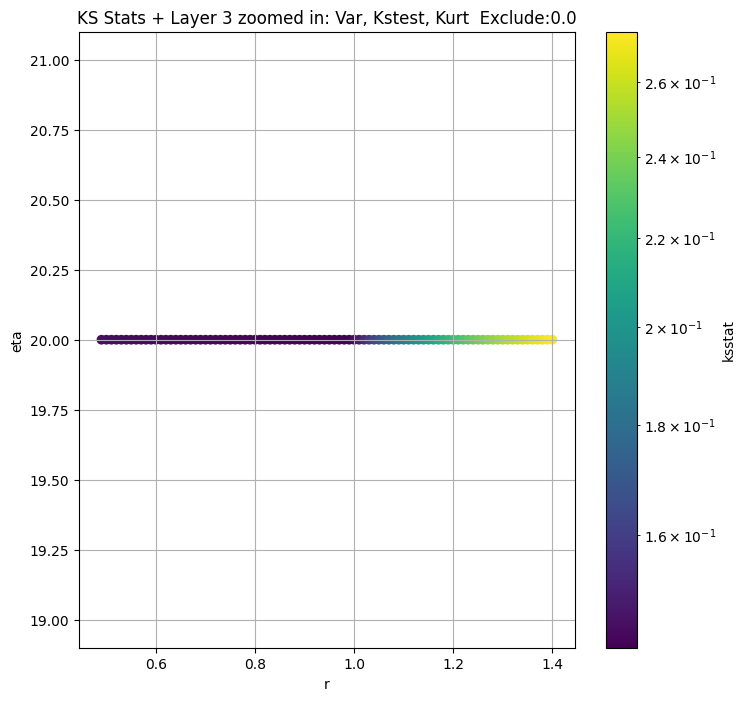

Layer 4


100%|██████████| 9/9 [00:00<00:00, 285.07it/s]


Finding Minimum after computing 9 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.022461958709144914, var: 171816.5


100%|██████████| 9/9 [00:00<00:00, 293.08it/s]


Finding Minimum after computing 9 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.021850808590798576, var: 173047.453125


100%|██████████| 9/9 [00:00<00:00, 276.73it/s]


Finding Minimum after computing 9 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.02121036834829415, var: 174402.859375


100%|██████████| 9/9 [00:00<00:00, 287.34it/s]


Finding Minimum after computing 9 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.02043633474752804, var: 176004.4375


100%|██████████| 9/9 [00:00<00:00, 284.31it/s]

Finding Minimum after computing 9 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.019374906087038846, var: 178325.15625
Number of samples: 100000, Without approximation : 180942.0


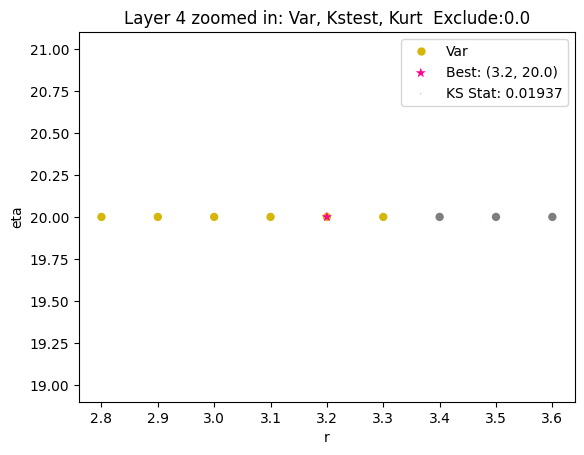

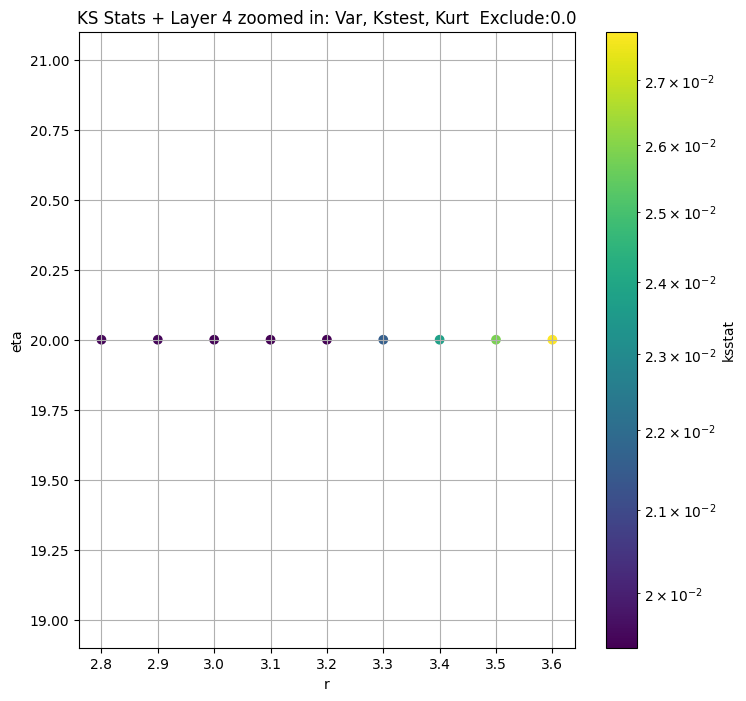

Layer 5


100%|██████████| 621/621 [00:02<00:00, 288.65it/s]


Finding Minimum after computing 621 CDFs
layer 5, 200.0 + 100 = 300, ksstat: 0.007279073462104657, var: 82989.0234375


100%|██████████| 621/621 [00:02<00:00, 298.87it/s]


Finding Minimum after computing 621 CDFs
layer 5, 200.0 + 75 = 275, ksstat: 0.007083595691196388, var: 83922.859375


100%|██████████| 621/621 [00:02<00:00, 293.44it/s]


Finding Minimum after computing 621 CDFs
layer 5, 200.0 + 50 = 250, ksstat: 0.006818621358435613, var: 84883.2109375


100%|██████████| 621/621 [00:02<00:00, 300.08it/s]


Finding Minimum after computing 621 CDFs
layer 5, 200.0 + 25 = 225, ksstat: 0.006591829684674644, var: 85873.859375


100%|██████████| 621/621 [00:02<00:00, 294.36it/s]


Finding Minimum after computing 621 CDFs
layer 5, 200.0 + 0 = 200, ksstat: 0.006386800579550335, var: 86899.53125


100%|██████████| 621/621 [00:02<00:00, 300.92it/s]


Finding Minimum after computing 621 CDFs
layer 5, 200.0 + -25 = 175, ksstat: 0.0061458837205317085, var: 87963.234375


100%|██████████| 621/621 [00:02<00:00, 298.00it/s]


Finding Minimum after computing 621 CDFs
layer 5, 200.0 + -50 = 150, ksstat: 0.006696819979198743, var: 89068.28125


100%|██████████| 621/621 [00:02<00:00, 292.70it/s]


Finding Minimum after computing 621 CDFs
layer 5, 200.0 + -75 = 125, ksstat: 0.0068597575262778765, var: 90215.921875


100%|██████████| 621/621 [00:02<00:00, 298.19it/s]


Finding Minimum after computing 621 CDFs
layer 5, 200.0 + -100 = 100, ksstat: 0.007155108804209553, var: 91413.546875
Number of samples: 100000, Without approximation : 922650.0


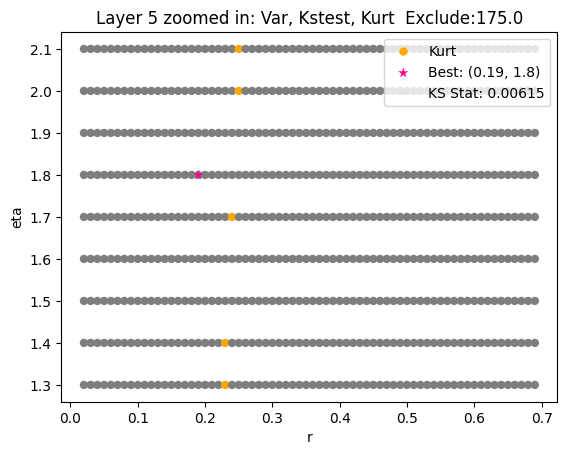

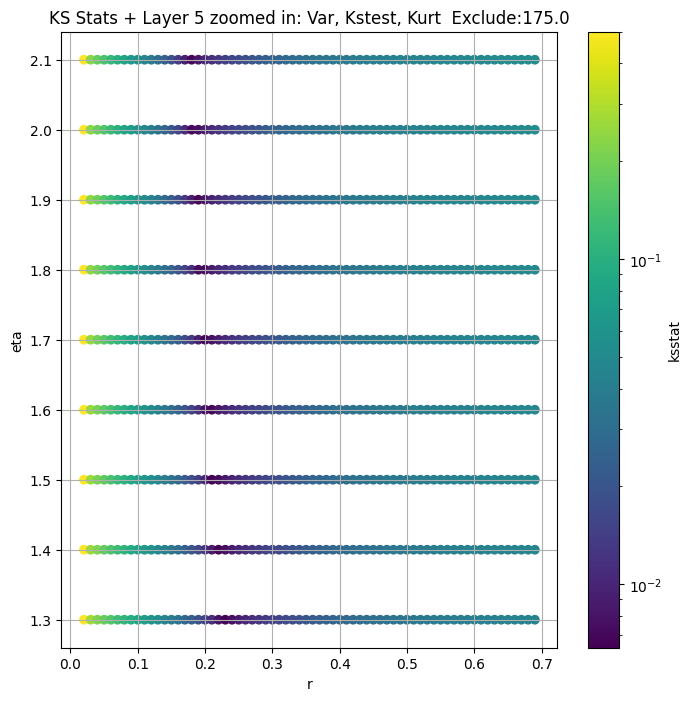

Layer 6


100%|██████████| 1665/1665 [00:05<00:00, 289.49it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 500.0 + 100 = 600, ksstat: 0.009105649326852538, var: 22545.64453125


100%|██████████| 1665/1665 [00:05<00:00, 292.10it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 500.0 + 75 = 575, ksstat: 0.008945706848695445, var: 22849.451171875


100%|██████████| 1665/1665 [00:05<00:00, 293.14it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 500.0 + 50 = 550, ksstat: 0.00873722896086734, var: 23160.99609375


100%|██████████| 1665/1665 [00:05<00:00, 293.76it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 500.0 + 25 = 525, ksstat: 0.008540046393138767, var: 23480.607421875


100%|██████████| 1665/1665 [00:05<00:00, 285.51it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 500.0 + 0 = 500, ksstat: 0.008331782807949112, var: 23808.46484375


100%|██████████| 1665/1665 [00:05<00:00, 292.03it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 500.0 + -25 = 475, ksstat: 0.008125446268560266, var: 24145.392578125


100%|██████████| 1665/1665 [00:05<00:00, 294.49it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 500.0 + -50 = 450, ksstat: 0.007918075733781782, var: 24491.62109375


100%|██████████| 1665/1665 [00:06<00:00, 270.05it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 500.0 + -75 = 425, ksstat: 0.008133459898522433, var: 24847.1953125


100%|██████████| 1665/1665 [00:05<00:00, 295.45it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 500.0 + -100 = 400, ksstat: 0.008673934325559851, var: 25212.5703125
Number of samples: 100000, Without approximation : 4185552.0


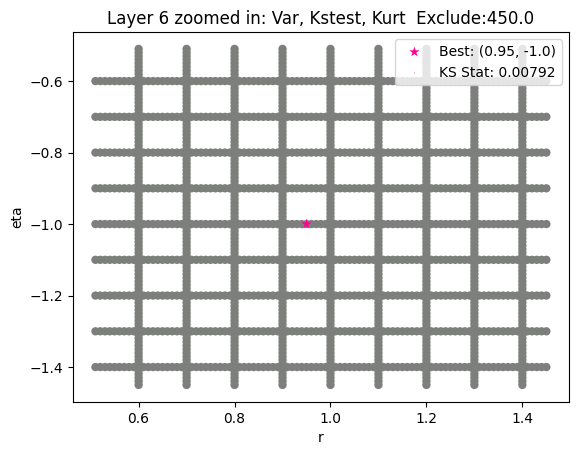

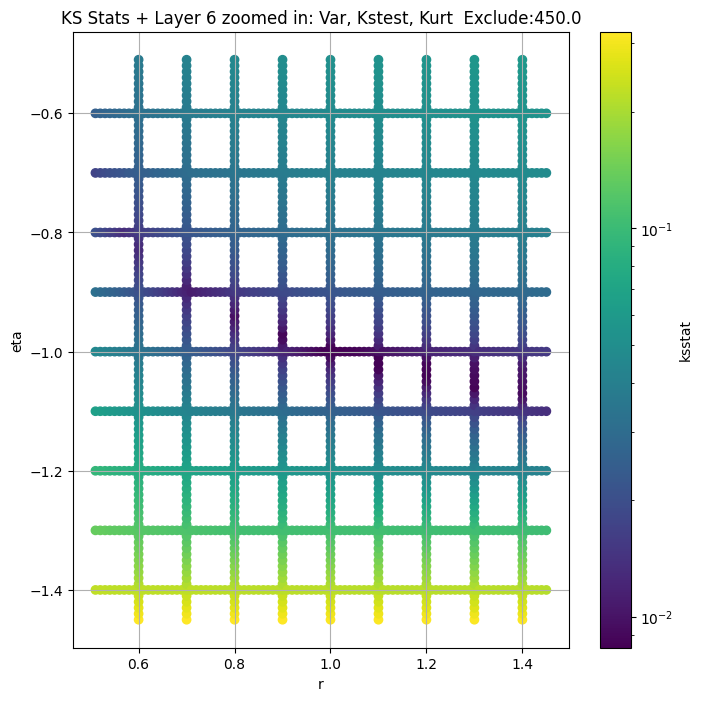

Layer 7


100%|██████████| 1656/1656 [00:05<00:00, 292.88it/s]


Finding Minimum after computing 1656 CDFs
layer 7, 100.0 + 100 = 200, ksstat: 0.00723953512513531, var: 6071.05224609375


100%|██████████| 1656/1656 [00:05<00:00, 294.13it/s]


Finding Minimum after computing 1656 CDFs
layer 7, 100.0 + 75 = 175, ksstat: 0.00714489511526635, var: 6171.02587890625


100%|██████████| 1656/1656 [00:05<00:00, 296.12it/s]


Finding Minimum after computing 1656 CDFs
layer 7, 100.0 + 50 = 150, ksstat: 0.00726845707134724, var: 6276.634765625


100%|██████████| 1656/1656 [00:05<00:00, 289.98it/s]


Finding Minimum after computing 1656 CDFs
layer 7, 100.0 + 25 = 125, ksstat: 0.00769160877118108, var: 6388.978515625


100%|██████████| 1656/1656 [00:05<00:00, 294.96it/s]


Finding Minimum after computing 1656 CDFs
layer 7, 100.0 + 0 = 100, ksstat: 0.00801744496285961, var: 6509.4833984375


100%|██████████| 1656/1656 [00:05<00:00, 293.31it/s]


Finding Minimum after computing 1656 CDFs
layer 7, 100.0 + -25 = 75, ksstat: 0.008336252104469644, var: 6639.798828125


100%|██████████| 1656/1656 [00:05<00:00, 295.66it/s]


Finding Minimum after computing 1656 CDFs
layer 7, 100.0 + -50 = 50, ksstat: 0.008375878447144658, var: 6782.3505859375


100%|██████████| 1656/1656 [00:05<00:00, 295.85it/s]


Finding Minimum after computing 1656 CDFs
layer 7, 100.0 + -75 = 25, ksstat: 0.008079208641316088, var: 6940.841796875


100%|██████████| 1656/1656 [00:05<00:00, 295.09it/s]


Finding Minimum after computing 1656 CDFs
layer 7, 100.0 + -100 = 0, ksstat: 0.008373569366292632, var: 7128.58740234375
Number of samples: 100000, Without approximation : 17688454.0


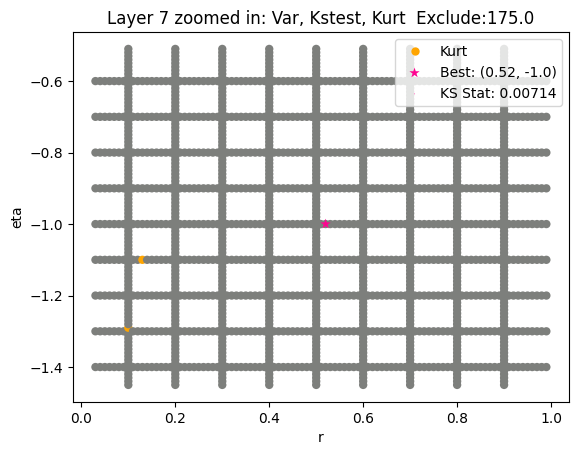

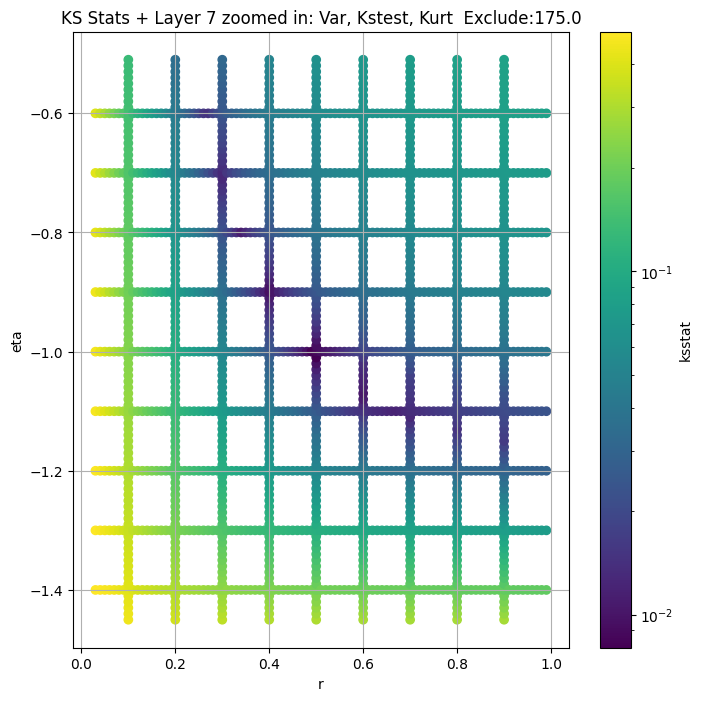

Layer 8


100%|██████████| 1656/1656 [00:05<00:00, 292.00it/s]


Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.005960340204421821, var: 580.1821899414062


100%|██████████| 1656/1656 [00:05<00:00, 293.85it/s]


Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.005640530525179516, var: 589.8287353515625


100%|██████████| 1656/1656 [00:05<00:00, 296.04it/s]


Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.005398348142036435, var: 599.9874877929688


100%|██████████| 1656/1656 [00:05<00:00, 294.38it/s]


Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.005559554146394197, var: 610.73095703125


100%|██████████| 1656/1656 [00:05<00:00, 294.66it/s]


Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.005546063530160961, var: 622.1575317382812


100%|██████████| 1656/1656 [00:05<00:00, 293.03it/s]


Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.005831262732132969, var: 634.3834838867188


100%|██████████| 1656/1656 [00:05<00:00, 290.84it/s]


Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.005542990009671178, var: 647.5550537109375


100%|██████████| 1656/1656 [00:05<00:00, 296.22it/s]


Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.005818243457037631, var: 661.88037109375


100%|██████████| 1656/1656 [00:05<00:00, 294.61it/s]


Finding Minimum after computing 1656 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.006099567785353255, var: 677.6448974609375
Number of samples: 100000, Without approximation : 72685058.0


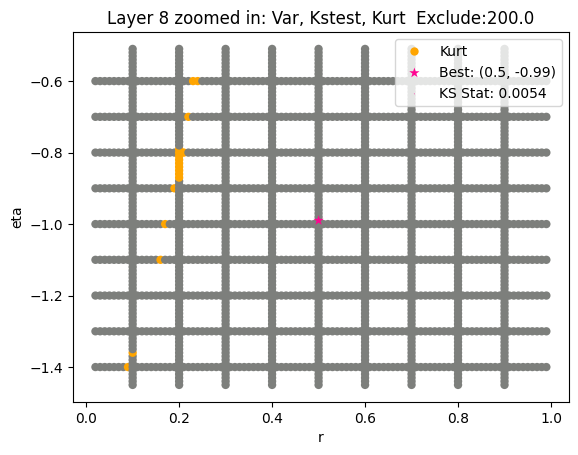

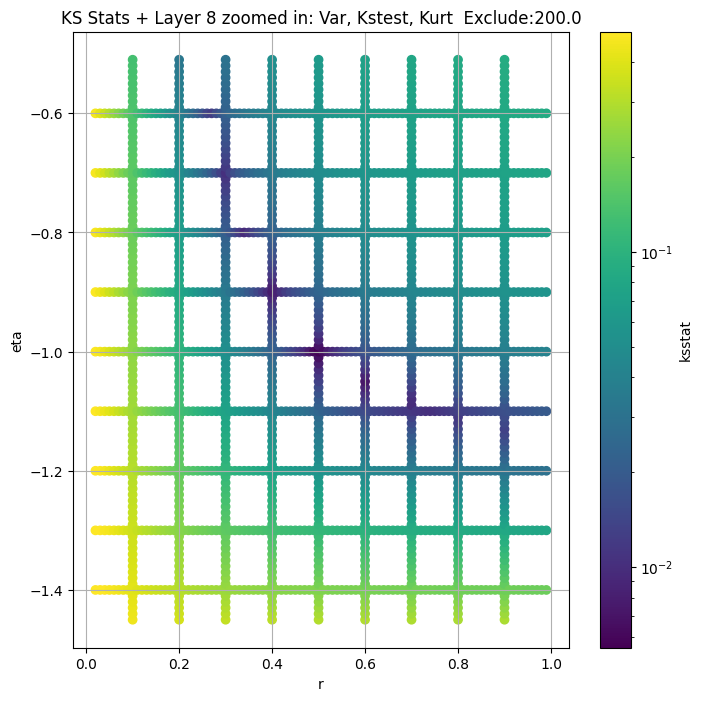

Layer 9


100%|██████████| 1332/1332 [00:04<00:00, 294.12it/s]


Finding Minimum after computing 1332 CDFs
layer 9, 75.0 + 100 = 175, ksstat: 0.0044283701532947806, var: 48.914039611816406


100%|██████████| 1332/1332 [00:04<00:00, 295.03it/s]


Finding Minimum after computing 1332 CDFs
layer 9, 75.0 + 75 = 150, ksstat: 0.004143305467484653, var: 50.1167106628418


100%|██████████| 1332/1332 [00:04<00:00, 296.08it/s]


Finding Minimum after computing 1332 CDFs
layer 9, 75.0 + 50 = 125, ksstat: 0.0037312122643146095, var: 51.42254638671875


100%|██████████| 1332/1332 [00:04<00:00, 296.01it/s]


Finding Minimum after computing 1332 CDFs
layer 9, 75.0 + 25 = 100, ksstat: 0.003672703575132996, var: 52.85530090332031


100%|██████████| 1332/1332 [00:04<00:00, 296.05it/s]


Finding Minimum after computing 1332 CDFs
layer 9, 75.0 + 0 = 75, ksstat: 0.00321076746150023, var: 54.45492172241211


100%|██████████| 1332/1332 [00:04<00:00, 296.26it/s]


Finding Minimum after computing 1332 CDFs
layer 9, 75.0 + -25 = 50, ksstat: 0.0035131730936166505, var: 56.30242156982422


100%|██████████| 1332/1332 [00:04<00:00, 296.15it/s]


Finding Minimum after computing 1332 CDFs
layer 9, 75.0 + -50 = 25, ksstat: 0.003733362423633868, var: 58.5856819152832


100%|██████████| 1332/1332 [00:04<00:00, 295.09it/s]


Finding Minimum after computing 1332 CDFs
layer 9, 75.0 + -75 = 0, ksstat: 0.0024792677116595163, var: 62.99375915527344
Number of samples: 100000, Without approximation : 295085108.0


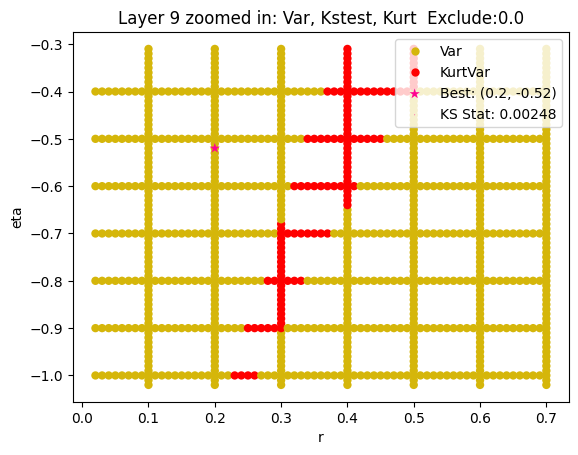

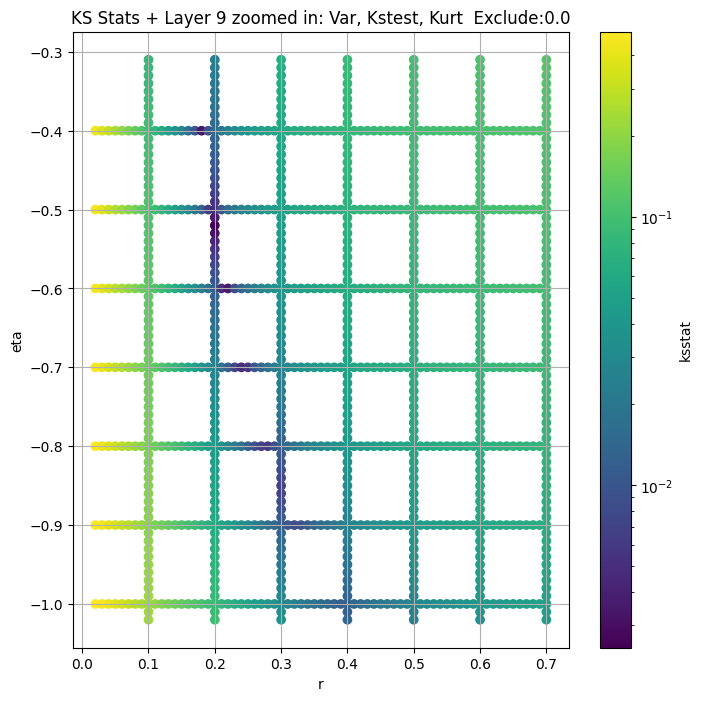

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.514066e+07  0.000000e+00  4.665707e+07  -1.892597         NaN   
3      2.194724e+06  2.157541e+06  2.231273e+06  -1.577773   -1.605638   
4      1.783252e+05  1.708648e+05  1.860050e+05   0.721045    0.336479   
5      9.722950e+04  9.013892e+04  1.045902e+05   6.273305    5.559395   
6      3.331691e+04  3.032871e+04  3.646762e+04  10.891587    9.727513   
7      7.128587e+03  6.485395e+03  7.798545e+03  10.925105    9.578980   
8      7.198787e+02  6.507919e+02  7.955521e+02  12.979091   10.335731   
9      6.299376e+01  5.491660e+01  7.264558e+01  27.372496   15.878567   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            4.0             0.299033        0.6         20.0   
3       -1.544034        20050.0             0.142043        0.9         20.0   
4        1.257031       180942.0             0.019375        3.2         20.0   
5        7.024289       922650.0             0.006395        0.2          1.7   
6       12.124202      4185552.0             0.008357        1.0         -1.0   
7       12.388499     17688454.0             0.008645        0.5         -1.0   
8       20.882729     72685058.0             0.005546        0.5         -1.0   
9       56.057470    295085108.0             0.004227        0.3         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       88852.581511                     0.0        3.514066e+07   
3       64407.782822                     0.0        2.194724e+06   
4       99928.072510                     0.0        1.783252e+05   
5           0.046708                   200.0        8.796323e+04   
6       47616.929688                   500.0        2.449162e+04   
7        3254.741699                   100.0        6.171026e+03   
8         311.078766                   150.0        5.999875e+02   
9           0.944401                    75.0        6.299376e+01   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.623939          0.299033    0.60     20.00   
3                     0.009583          0.141732    0.99     20.00   
4                     0.003192          0.019375    3.20     20.00   
5                     0.001414          0.006146    0.19      1.80   
6                     0.000664          0.007918    0.95     -1.00   
7                     0.000323          0.007145    0.52     -1.00   
8                     0.000159          0.005398    0.50     -0.99   
9                     0.000079          0.002479    0.20     -0.52   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      88852.581511                  0.0           19  
3      97942.754566                  0.0           87  
4      99928.072510                  0.0         4770  
5          0.014500                175.0        48654  
6      46327.615392                450.0        31036  
7       3504.207348                175.0        34547  
8        291.199518                200.0        63949  
9          0.004491                  0.0       288169

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

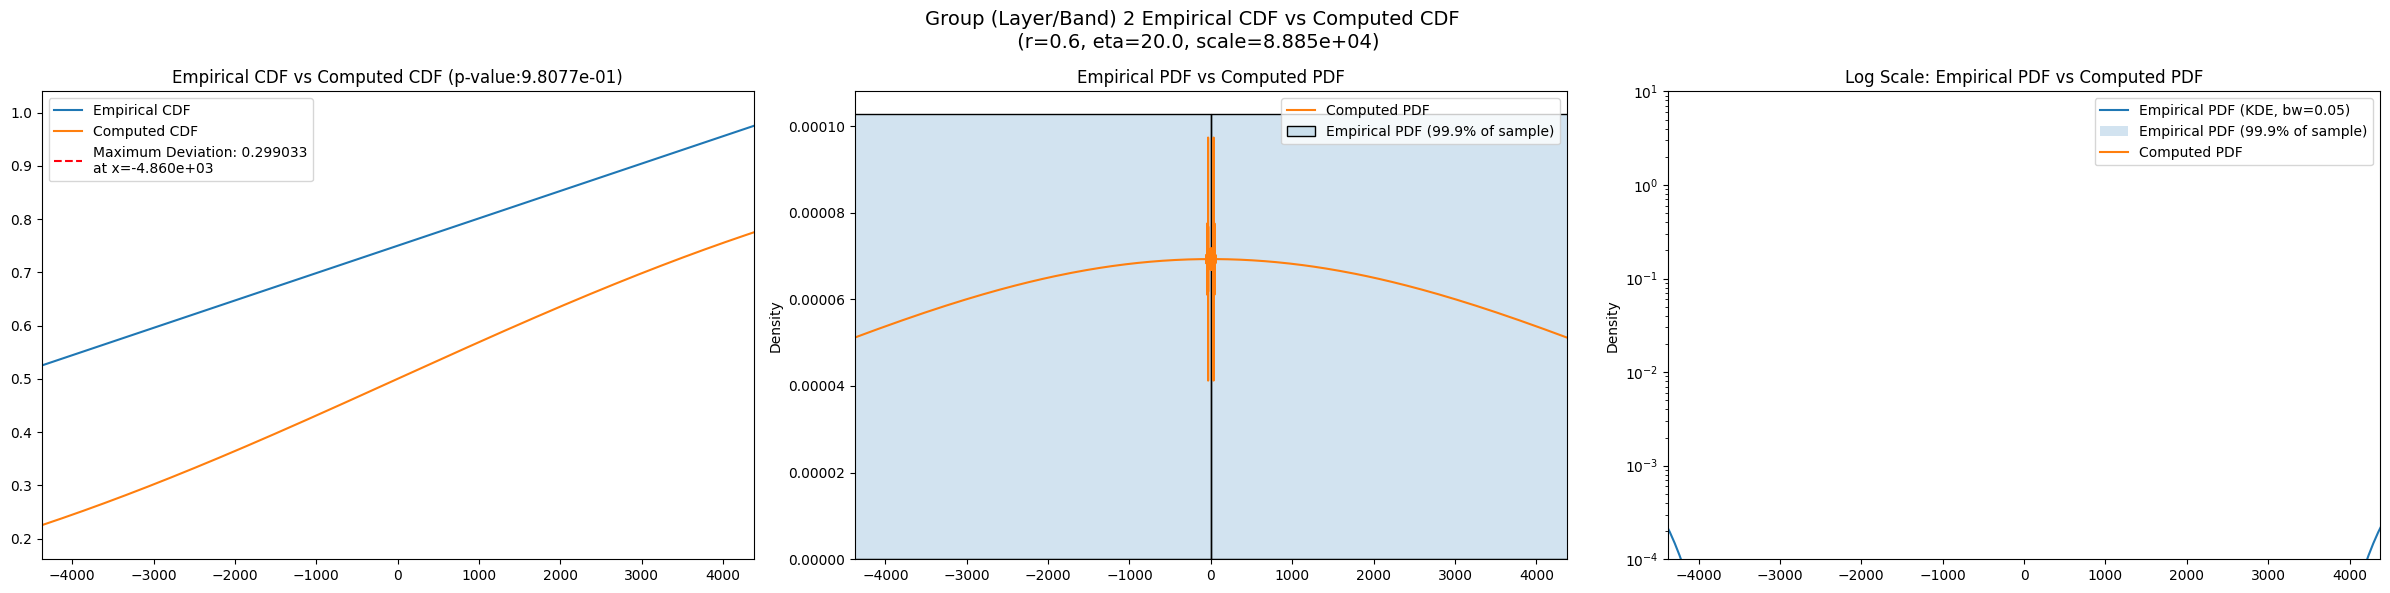

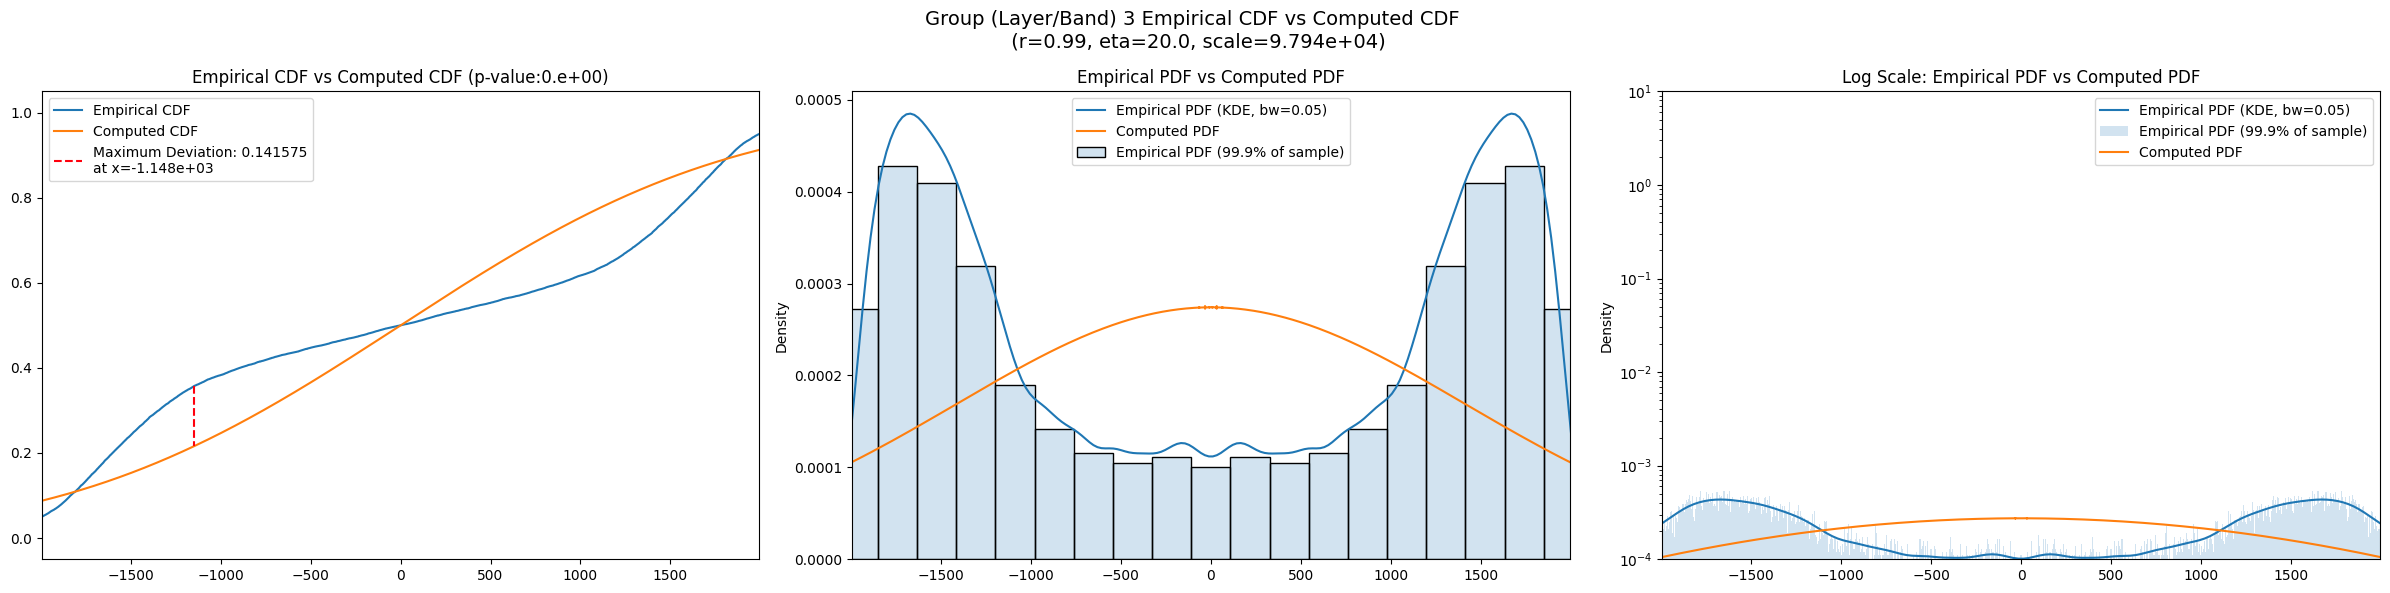

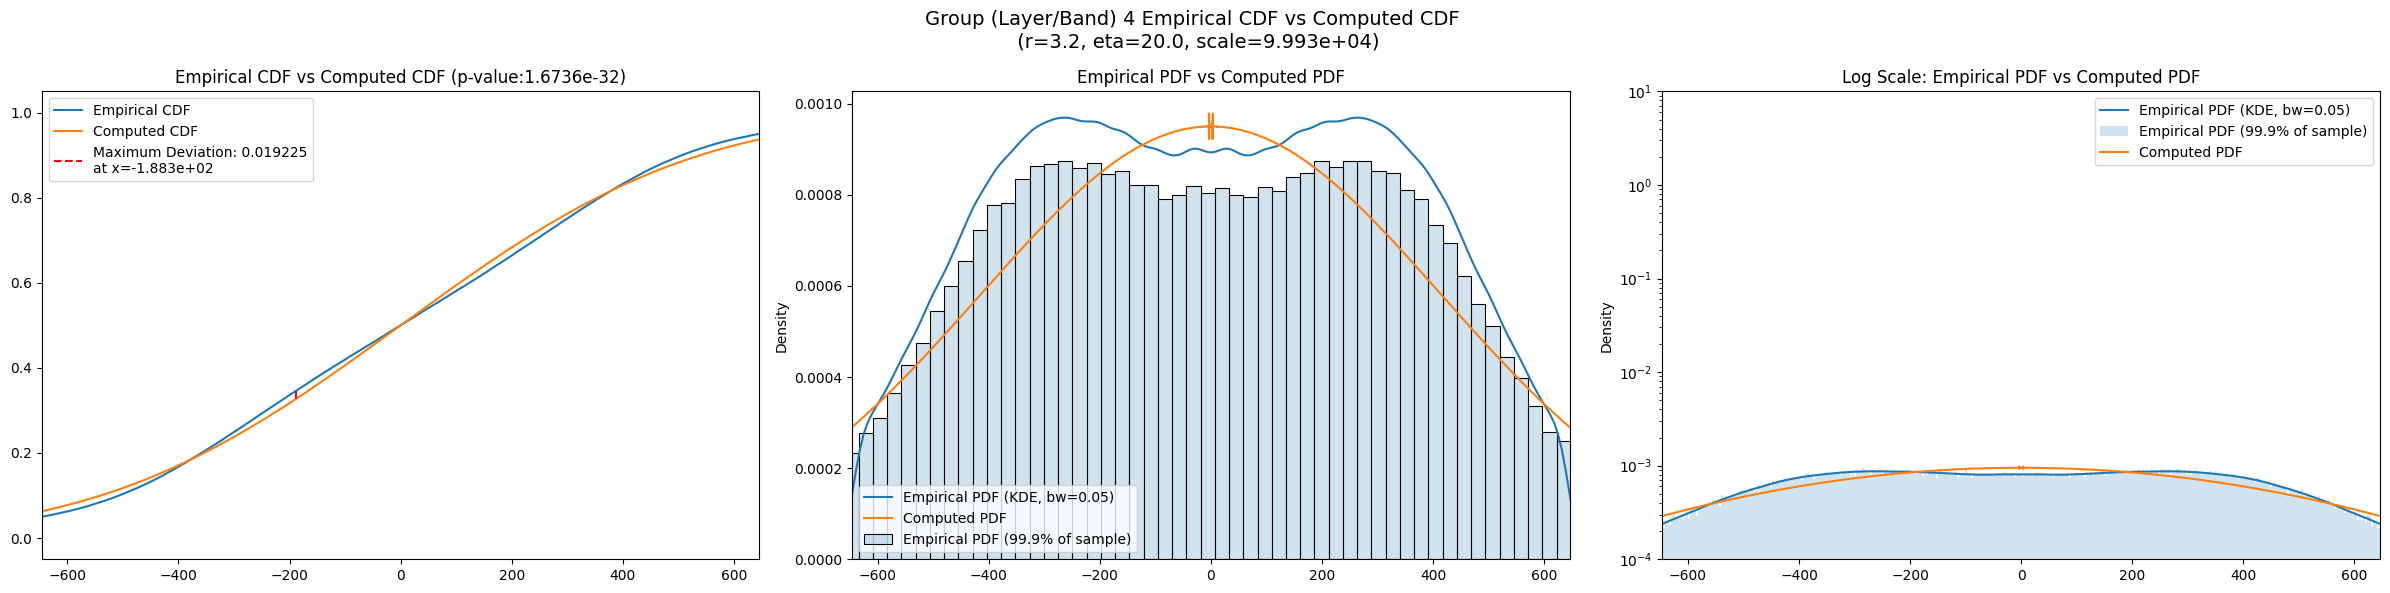

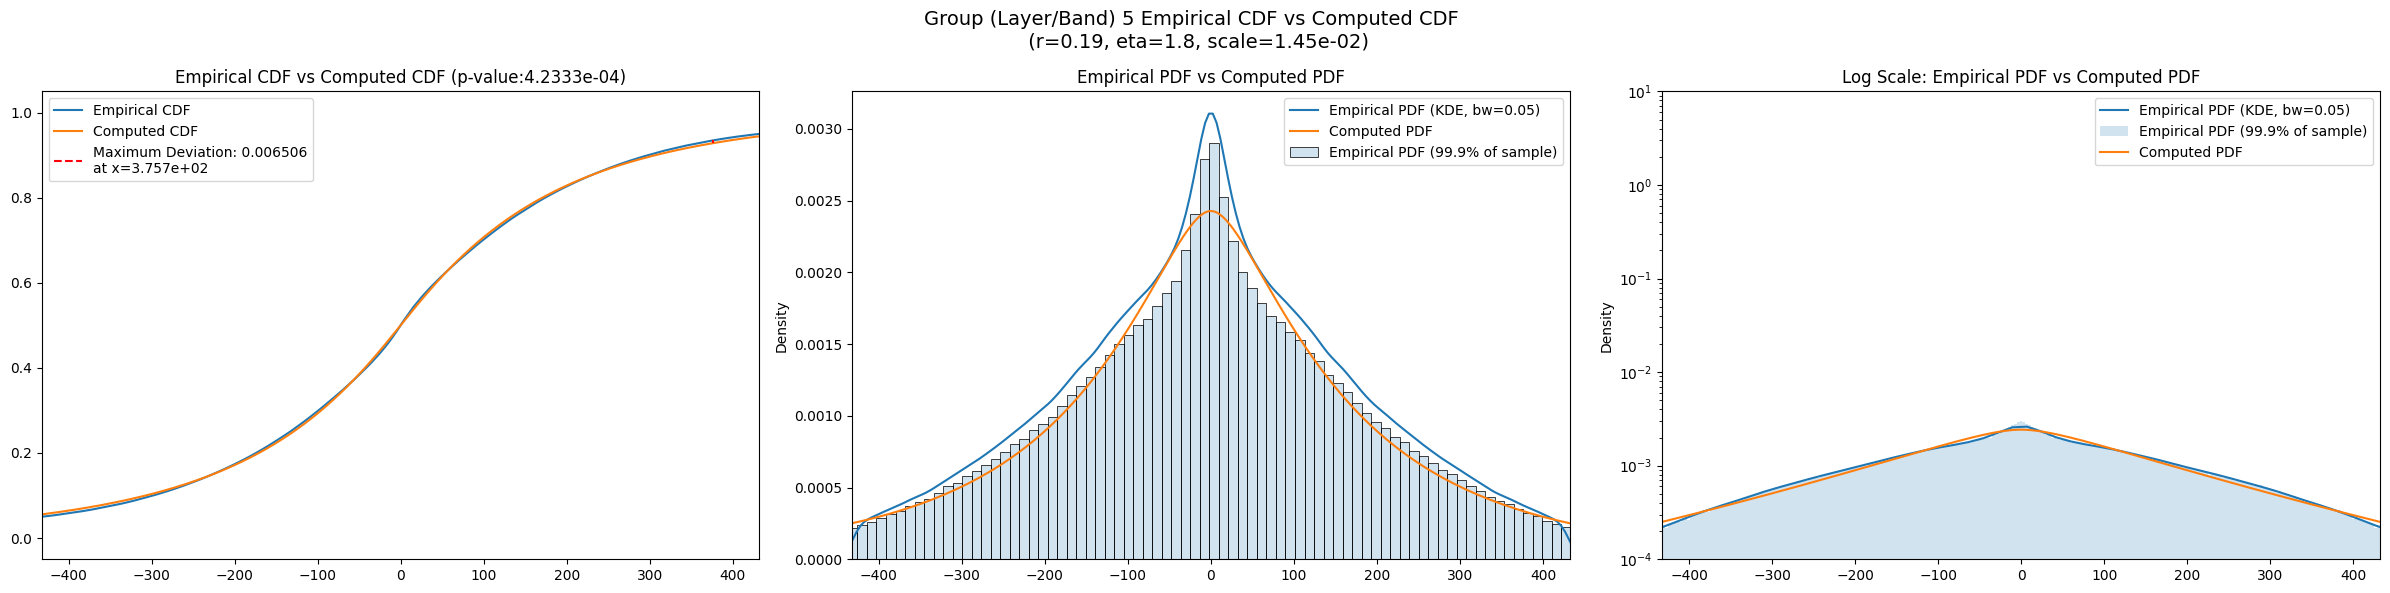

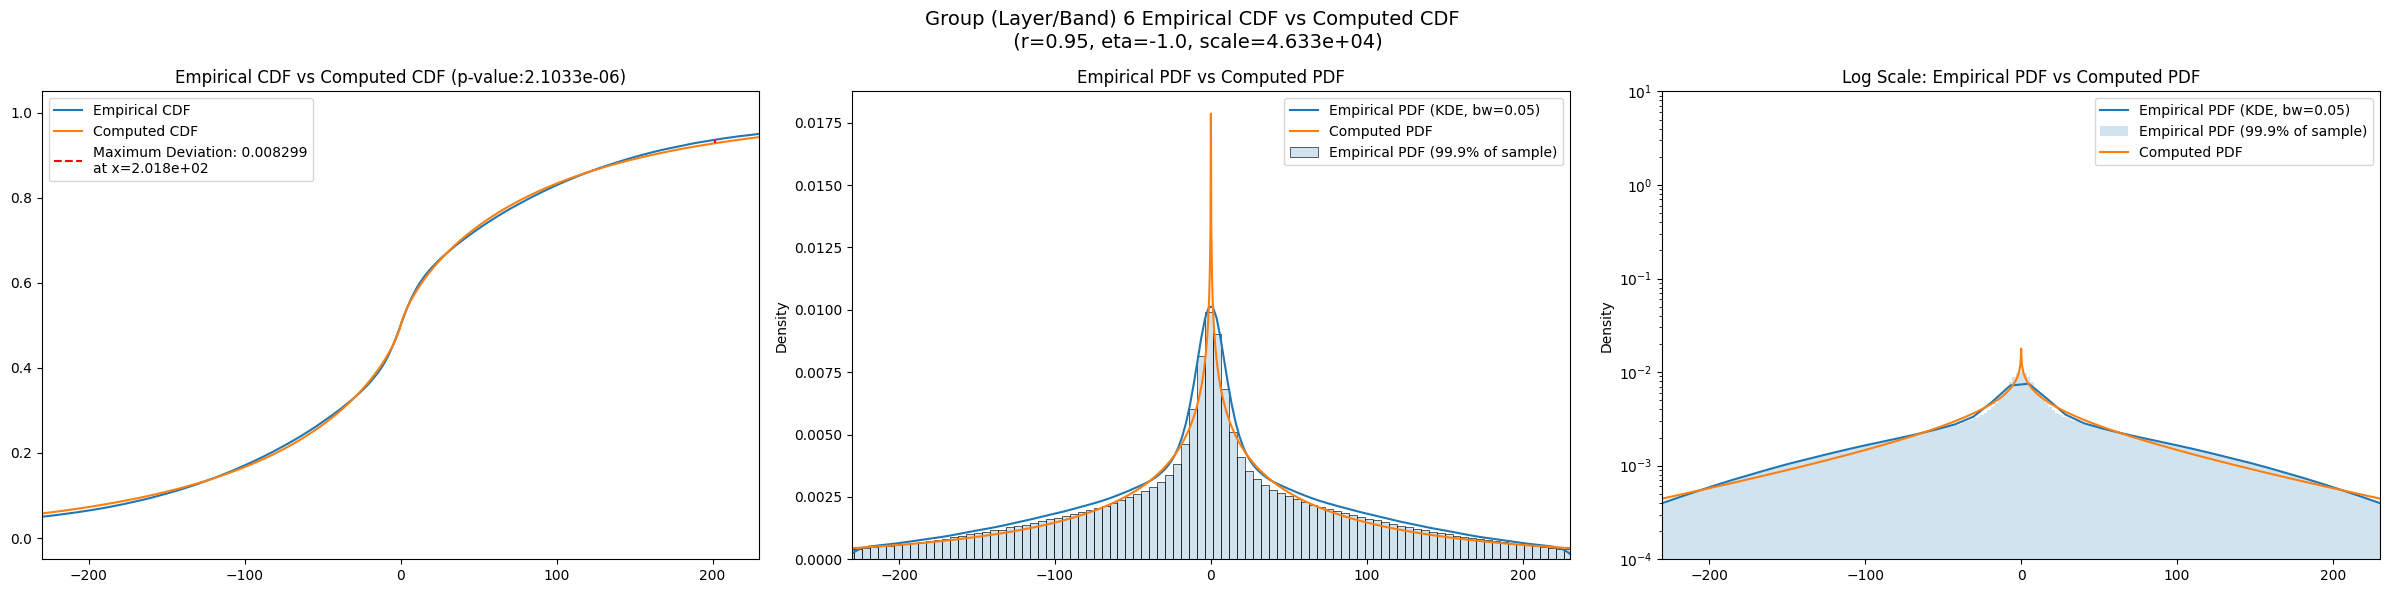

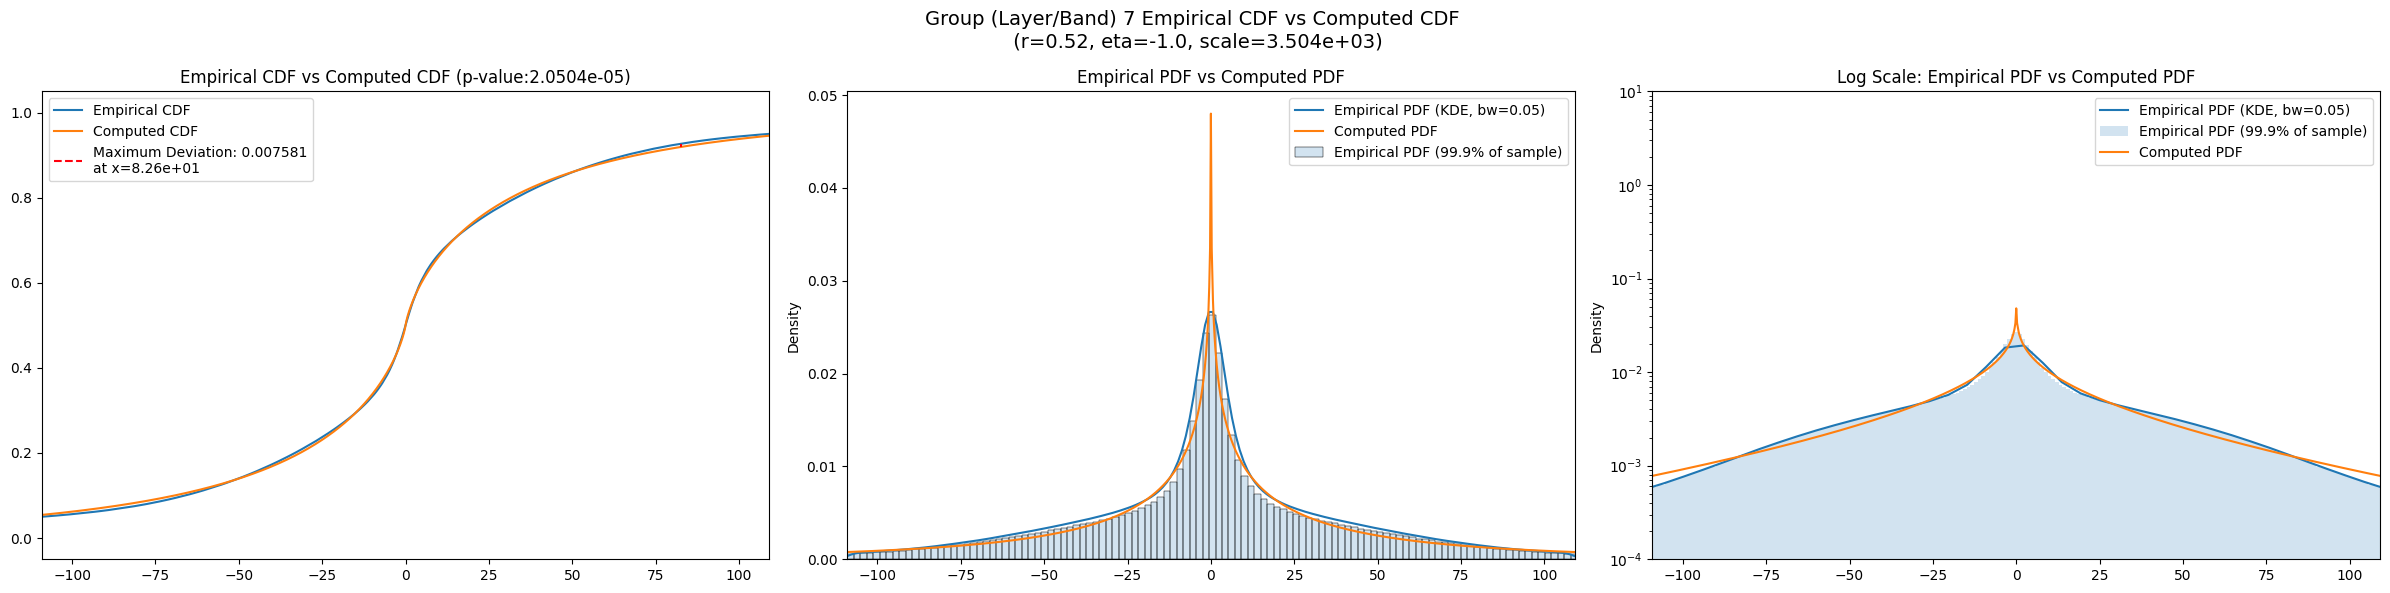

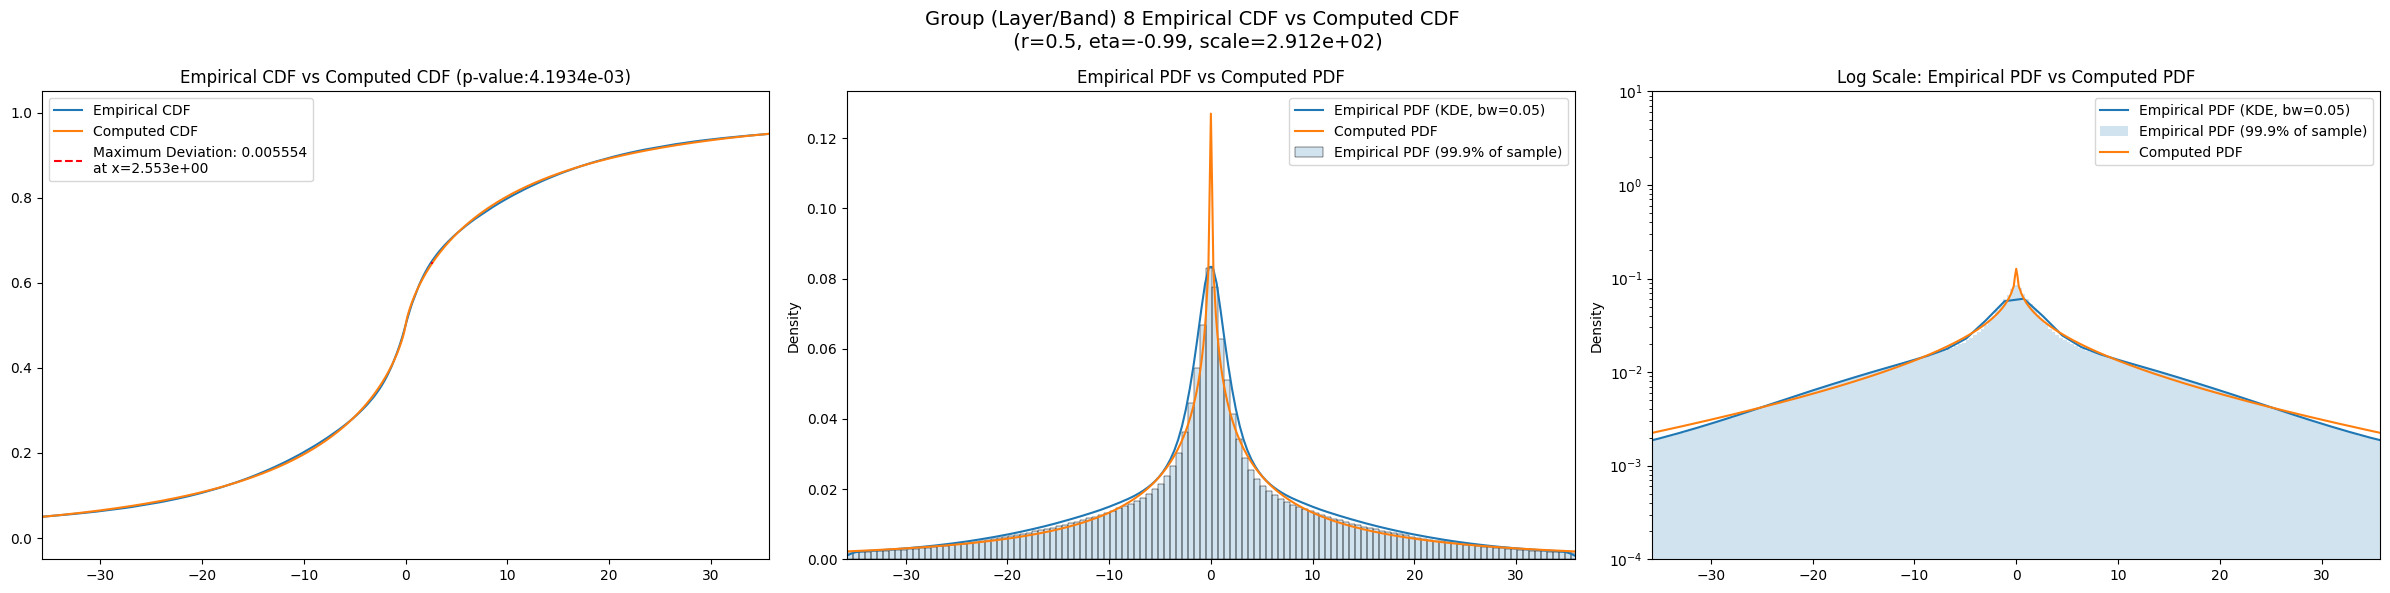

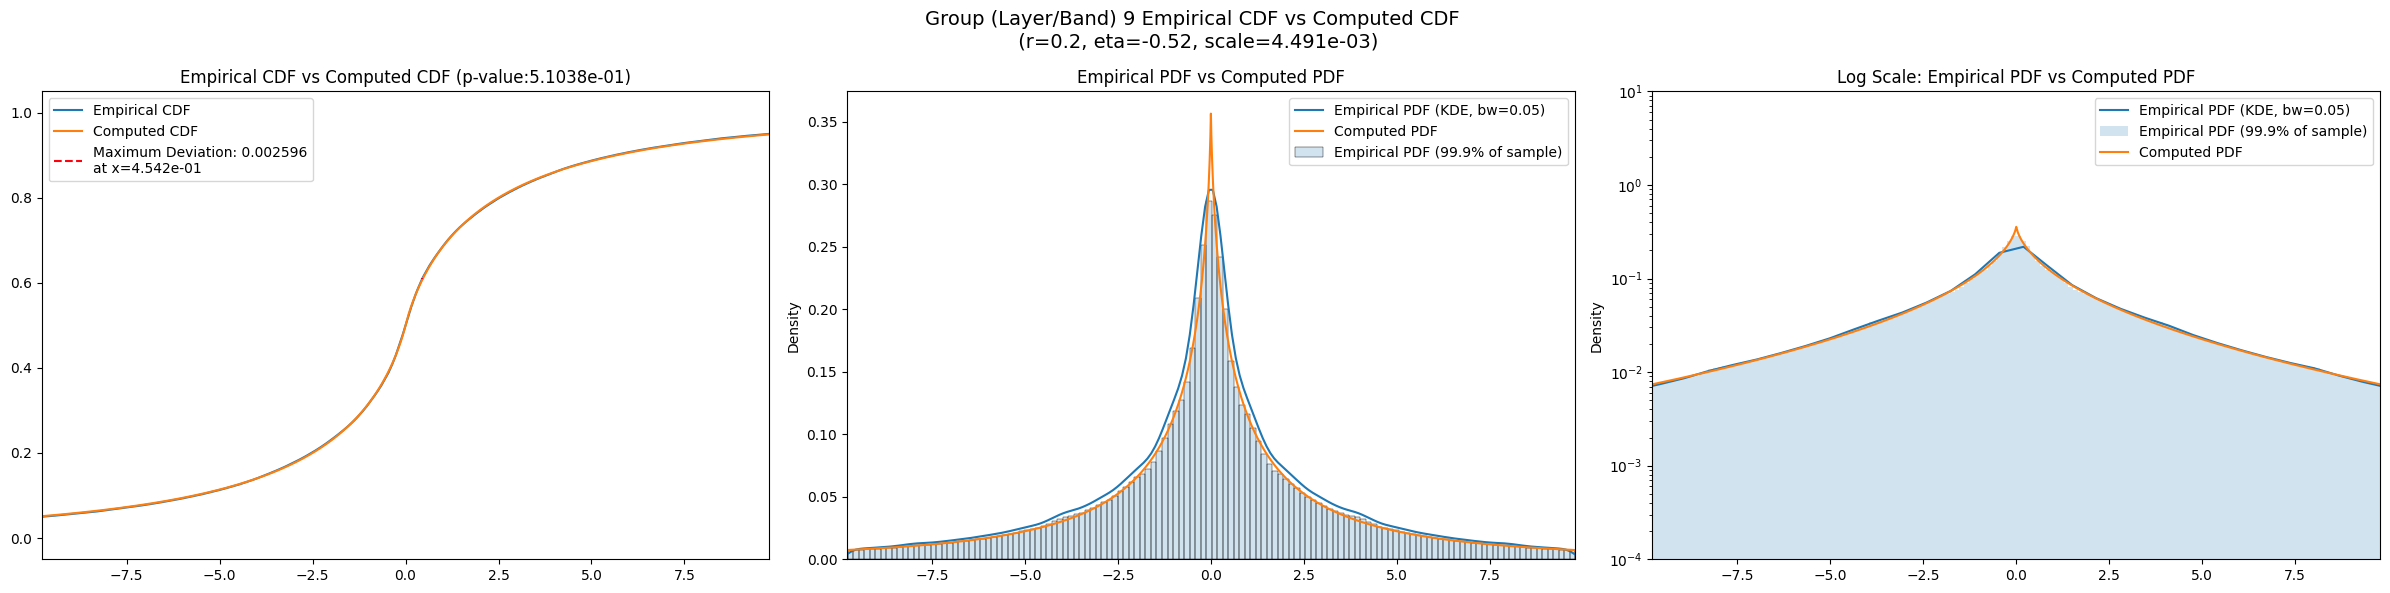

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.514066e+07  0.000000e+00  4.665707e+07  -1.892597         NaN   
3      2.194724e+06  2.157541e+06  2.231273e+06  -1.577773   -1.605638   
4      1.783252e+05  1.708648e+05  1.860050e+05   0.721045    0.336479   
5      9.722950e+04  9.013892e+04  1.045902e+05   6.273305    5.559395   
6      3.331691e+04  3.032871e+04  3.646762e+04  10.891587    9.727513   
7      7.128587e+03  6.485395e+03  7.798545e+03  10.925105    9.578980   
8      7.198787e+02  6.507919e+02  7.955521e+02  12.979091   10.335731   
9      6.299376e+01  5.491660e+01  7.264558e+01  27.372496   15.878567   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            4.0             0.299033        0.6         20.0   
3       -1.544034        20050.0             0.142043        0.9         20.0   
4        1.257031       180942.0             0.019375        3.2         20.0   
5        7.024289       922650.0             0.006395        0.2          1.7   
6       12.124202      4185552.0             0.008357        1.0         -1.0   
7       12.388499     17688454.0             0.008645        0.5         -1.0   
8       20.882729     72685058.0             0.005546        0.5         -1.0   
9       56.057470    295085108.0             0.004227        0.3         -0.8   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      8610.13000              0.213795          9.761280e-01   
3      ...      1802.20000              0.096978         1.398370e-164   
4      ...       425.27000              0.017369          7.572460e-48   
5      ...       219.34400              0.027165          0.000000e+00   
6      ...        93.75000              0.051297          0.000000e+00   
7      ...        37.29170              0.062661          0.000000e+00   
8      ...        11.81620              0.064109          0.000000e+00   
9      ...         3.22741              0.063568          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         8349.69000             0.220642         9.678690e-01  7082.41000   
3         1619.26000             0.114939        3.296660e-231  1384.31000   
4          381.49500             0.041623        7.993540e-273   317.48100   
5          196.89500             0.009738         2.016820e-76   156.43000   
6           80.28050             0.028702         0.000000e+00    66.59830   
7           31.89690             0.037617         0.000000e+00    26.08770   
8           10.14260             0.038257         0.000000e+00     8.16387   
9            2.80098             0.037622         0.000000e+00     2.18670   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.218290   9.709150e-01          7.737869e-01  
3           0.113036  1.312170e-223          0.000000e+00  
4           0.039753  6.930180e-249          1.964107e-59  
5           0.009534   2.783750e-73          1.067770e-30  
6           0.035174   0.000000e+00         2.323733e-228  
7           0.043057   0.000000e+00          0.000000e+00  
8           0.042058   0.000000e+00          0.000000e+00  
9           0.038707   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.299033                 0.623939          0.299033   
3                 0.142043                 0.009583          0.141732   
4                 0.019375                 0.003192          0.019375   
5                 0.006395                 0.001414          0.006146   
6                 0.008357                 0.000664          0.007918   
7                 0.008645                 0.000323          0.007145   
8                 0.005546                 0.000159          0.005398   
9                 0.004227                 0.000079          0.002479   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.213795             0.220642       0.218290  
3                  0.096978             0.114939       0.113036  
4                  0.017369             0.041623       0.039753  
5                  0.027165             0.009738       0.009534  
6                  0.051297             0.028702       0.035174  
7                  0.062661             0.037617       0.043057  
8                  0.064109             0.038257       0.042058  
9                  0.063568             0.037622       0.038707

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            3.514066e+07          0.299033    0.60     20.00  88852.581511   
3            2.194724e+06          0.141732    0.99     20.00  97942.754566   
4            1.783252e+05          0.019375    3.20     20.00  99928.072510   
5            8.796323e+04          0.006146    0.19      1.80      0.014500   
6            2.449162e+04          0.007918    0.95     -1.00  46327.615392   
7            6.171026e+03          0.007145    0.52     -1.00   3504.207348   
8            5.999875e+02          0.005398    0.50     -0.99    291.199518   
9            6.299376e+01          0.002479    0.20     -0.52      0.004491   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    175.0  
6                    450.0  
7                    175.0  
8                    200.0  
9                      0.0

In [21]:
eng.quit()